##Algoritmo EM:

###Parte 1: dados simulados
A ideia aqui é separar ao máximo os dados simulados da recuperação de parâmetros, para garantir que o programa não esteja "trapaceando", e usando informação que não deveria

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Definindo variáveis
n_var = 8
lam_true = np.array([8.0, 2.0, 1.0, 4.5, 8.5, 4.5, 1.5, 1.3])  #  para as Poisson de verdade, pode alterar se quiser
p_true = np.array([0.53122461, 0.47473989, 0.4704848,  0.14325829, 0.64549933, 0.80112796, 0.2255324,  0.76525063]) #esse é o caso que usamos pi's conhecidos, proporcionais às areas
n_var = len(lam_true)

# No de amostras- note que estou adaptando para o meu formato de dados em que se dispersam as observações uniformemente, para não ter que ficar lidando
# com um termo "Nct" ou algo do tipo, as observações são distribuídas uiformemente em amostras
n_amost = 100

# ##############################################################################
def gera_dados(lam_true, p_true, n_amost):
    Y = []
    S = np.zeros(n_amost)
    for i in range(len(lam_true)):
        X_i = poisson.rvs(p_true[i] * lam_true[i], size=n_amost)
        Y_i = poisson.rvs((1 - p_true[i]) * lam_true[i], size=n_amost)
        Y.append(Y_i)
        S += X_i
    Y = np.array(Y)
    return Y, S
# ##############################################################################
Y, S = gera_dados(lam_true, p_true, n_amost)
dados = {
    f'Y{i+1}': Y[i] for i in range(n_var)
}
dados['S'] = S
df = pd.DataFrame(dados)   ## coloco tudo num df ###############################
print(df.head())
# ##############################################################################
### SALVE NUM DF ##################
df.to_csv('sim_data.csv', index=False)
# ################################

   Y1  Y2  Y3  Y4  Y5  Y6  Y7  Y8     S
0   3   0   0   4   2   1   0   0  17.0
1   1   2   0   6   8   0   1   0  20.0
2   2   0   0   4   2   2   1   0  23.0
3   3   2   1   3   2   0   0   1  18.0
4   3   1   1   3   3   0   1   0  21.0


Eu salvei num df, agora é importante **Reinicializar o Sistema**, para testar se não ha contaminação, e reimportar os dados

In [ ]:
import pandas as pd
df = pd.read_csv('sim_data.csv')
print(df.head())

   Y1  Y2  Y3  Y4  Y5  Y6  Y7  Y8     S
0   3   0   0   4   2   1   0   0  17.0
1   1   2   0   6   8   0   1   0  20.0
2   2   0   0   4   2   2   1   0  23.0
3   3   2   1   3   2   0   0   1  18.0
4   3   1   1   3   3   0   1   0  21.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson


# coloque aqui a proporção das zonas ###########################################
p_verd = np.array([0.53122461, 0.47473989, 0.4704848, 0.14325829, 0.64549933, 0.80112796, 0.2255324, 0.76525063])

#################################################################################
def em_algoritmo_df(df, p_verd, max_it=100, tol=1e-6):
    n_var = len(df.columns) - 1
    n = len(p_verd)
    l_estim = np.ones(n)  # Inicializa lambda com 1- pode melhorar se tiver uma "priori"
    hist_l = [l_estim.copy()]  # histórico das est
    hist_ll = []  # histórico da veross.

    Y = np.array([df[f'Y{i+1}'].values for i in range(n_var)])
    S = df['S'].values

    def log_verossim(l_estim): ### log veross, para os lambdas atuais
        X_cond = np.array([
            S * (p_verd[i] * l_estim[i]) / np.sum(p_verd * l_estim)
            for i in range(n)
        ])
        return np.sum([
            np.sum(X_cond[i] * np.log(p_verd[i] * l_estim[i])
                   - p_verd[i] * l_estim[i])
            + np.sum(Y[i] * np.log((1 - p_verd[i]) * l_estim[i])
                   - (1 - p_verd[i]) * l_estim[i])
            for i in range(n)
        ])

    for _ in range(max_it):
        # Etapa E, esperança condicional ######################################
        X_cond = np.array([
            S * (p_verd[i] * l_estim[i]) / np.sum(p_verd * l_estim)
            for i in range(n)
        ])

        # Etapa M: Atualizar lambda como argmax calculado  ####################
        l_novo = np.array([
            np.mean(X_cond[i] + Y[i])
            for i in range(n)
        ])

        # histórico
        hist_l.append(l_novo.copy())
        ll_val = log_verossim(l_novo)
        hist_ll.append(ll_val)

        # Aqui eu verifico a convergência da verossimilhança- parada na esabilização
        if np.all(np.abs(l_novo - l_estim) < tol):
            break

        l_estim = l_novo

    return l_estim, hist_l, hist_ll



# chamando
l_estimado, hist_l, hist_ll = em_algoritmo_df(df, p_verd)

# Plotar a evolução das estimativas e da verossimilhança
plt.figure(figsize=(14, 7))

# Plotar a evolução das estimativas dos parâmetros
plt.subplot(1, 2, 1)
for i in range(len(l_estimado)):
    plt.plot([l[i] for l in hist_l], label=f'λ{i+1}', marker='o')
#caso queira comparar com o lambda real, pode não reinicialar o sistema acima
#plt.axhline(y=lambda_true[0], color='r', linestyle='--', label='True λ1')
#plt.axhline(y=lambda_true[-1], color='b', linestyle='--', label='True λ20')

plt.xlabel('Iteração')
plt.ylabel('Parâmetros Estimados')
plt.title('Evolução das Estimativas dos Parâmetros')
plt.legend()
plt.grid(True)

# Plotar a trajetória da verossimilhança
plt.subplot(1, 2, 2)
plt.plot(hist_ll, marker='o', color='purple')
plt.xlabel('Iteração')
plt.ylabel('Log-Verossimilhança')
plt.title('Log-Verossimilhança ao Longo das Iterações')
plt.grid(True)

plt.tight_layout()
plt.show()

#print("Parâmetros verdadeiros:", lambda_true)
print("Parâmetros estimados:", l_estimado)


NameError: name 'df' is not defined

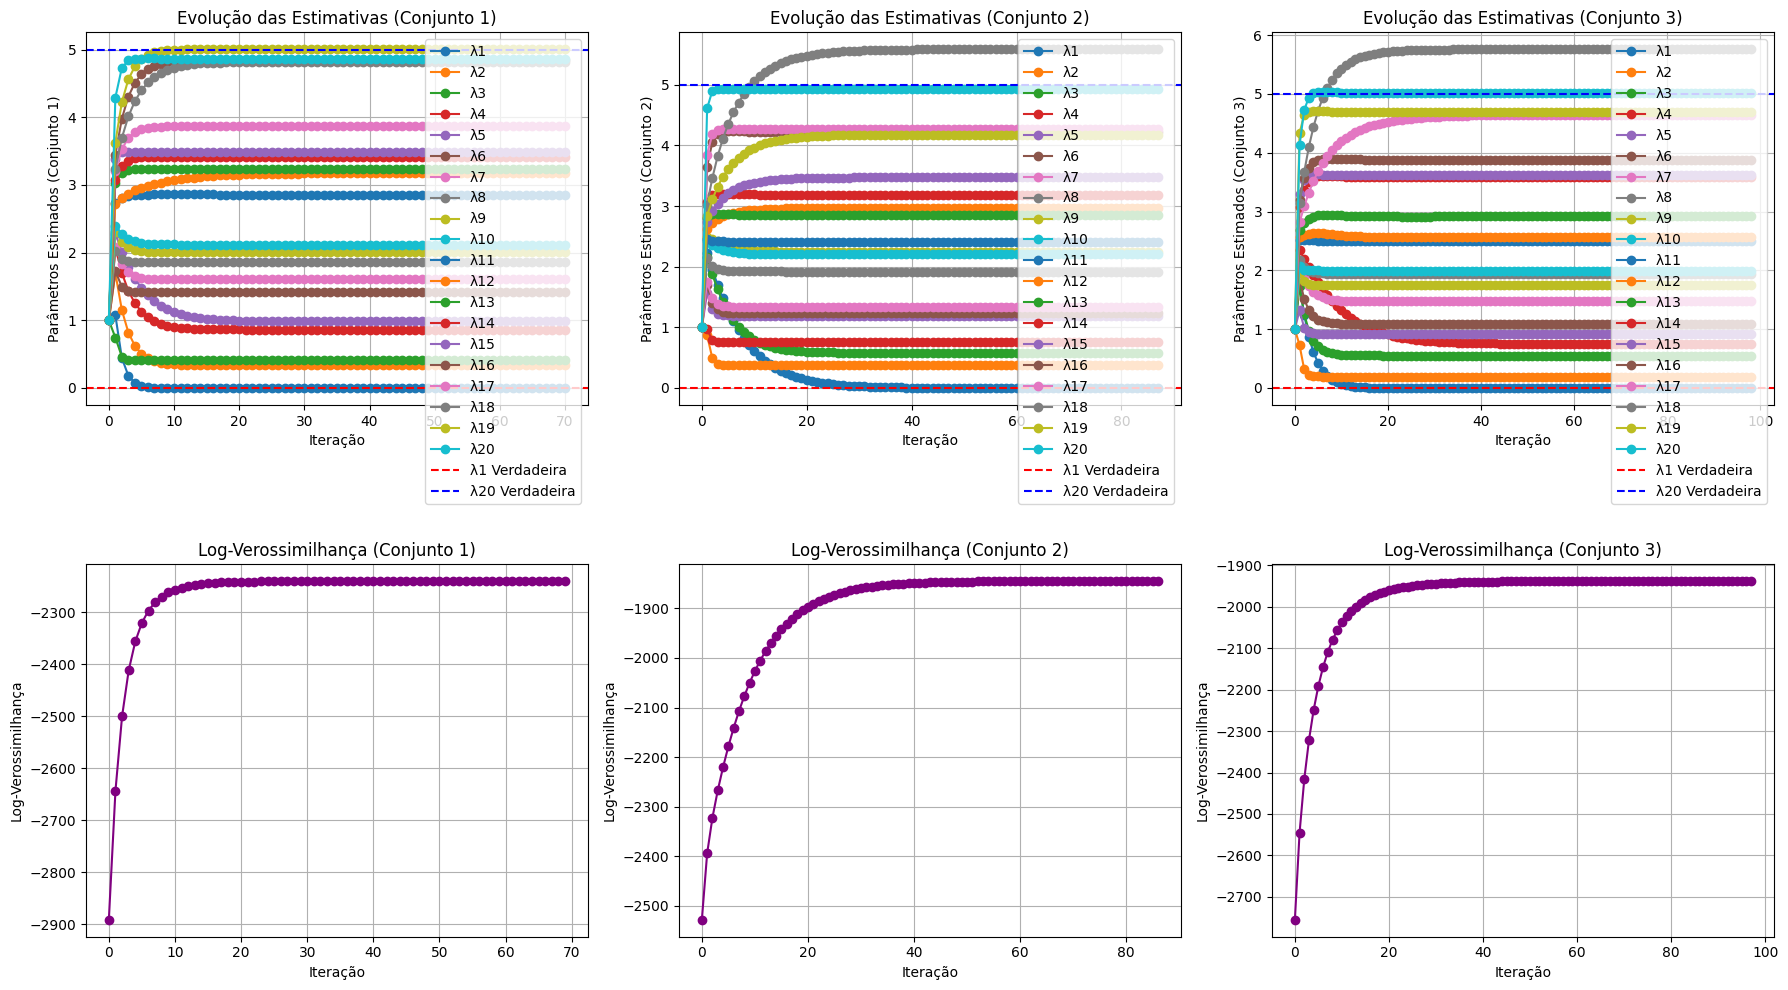

Parâmetros verdadeiros (Conjunto 1): [0.         0.26315789 0.52631579 0.78947368 1.05263158 1.31578947
 1.57894737 1.84210526 2.10526316 2.36842105 2.63157895 2.89473684
 3.15789474 3.42105263 3.68421053 3.94736842 4.21052632 4.47368421
 4.73684211 5.        ]
Parâmetros estimados (Conjunto 1): [2.27741453e-27 3.38822082e-01 4.11019912e-01 8.62935211e-01
 9.83793908e-01 1.41348519e+00 1.60472179e+00 1.85862743e+00
 2.00446623e+00 2.11770097e+00 2.85721051e+00 3.17330919e+00
 3.23802066e+00 3.41500839e+00 3.49122616e+00 4.84214592e+00
 3.86541137e+00 4.81310722e+00 5.00228038e+00 4.86670747e+00]
Parâmetros verdadeiros (Conjunto 2): [0.         0.26315789 0.52631579 0.78947368 1.05263158 1.31578947
 1.57894737 1.84210526 2.10526316 2.36842105 2.63157895 2.89473684
 3.15789474 3.42105263 3.68421053 3.94736842 4.21052632 4.47368421
 4.73684211 5.        ]
Parâmetros estimados (Conjunto 2): [6.62303219e-06 3.74080944e-01 5.79069280e-01 7.58298238e-01
 1.19147631e+00 1.23347782e+00 1.334156

In [ ]:
#@title Expandindo para várias categorias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson


n_var = 20
lambda_v = np.linspace(2, 5, n_var)
p_v = np.random.uniform(0.1, 0.9, (n_var, 3))

n_amostras = 100

def gerar_dados(lambda_v, p_v, n_amostras):
    Y = np.zeros((n_var, 3, n_amostras))
    S = np.zeros((3, n_amostras))
    for i in range(n_var):
        for j in range(3):
            X_ij = poisson.rvs(p_v[i, j] * lambda_v[i], size=n_amostras)
            Y_ij = poisson.rvs((1 - p_v[i, j]) * lambda_v[i], size=n_amostras)
            Y[i, j] = Y_ij
            S[j] += X_ij
    return Y, S

Y, S = gerar_dados(lambda_v, p_v, n_amostras)

dados = {}
for j in range(3):
    for i in range(n_var):
        dados[f'Y{i+1}_{j+1}'] = Y[i, j]
    dados[f'S{j+1}'] = S[j]

df = pd.DataFrame(dados)

def em_algoritmo(df, p_v, j, max_iter=100, tol=1e-6):
    n = len(p_v)
    lambda_e = np.ones(n)
    lambda_hist = [lambda_e.copy()]
    log_like_hist = []

    Y = np.array([df[f'Y{i+1}_{j+1}'].values for i in range(n)])
    S = df[f'S{j+1}'].values

    def log_verossim(lambda_e):
        X_cond_mean = np.array([
            S * (p_v[i, j] * lambda_e[i]) / np.sum(p_v[:, j] * lambda_e)
            for i in range(n)
        ])
        return np.sum([
            np.sum(X_cond_mean[i] * np.log(p_v[i, j] * lambda_e[i])
                   - p_v[i, j] * lambda_e[i])
            + np.sum(Y[i] * np.log((1 - p_v[i, j]) * lambda_e[i])
                   - (1 - p_v[i, j]) * lambda_e[i])
            for i in range(n)
        ])

    for _ in range(max_iter):
        X_cond_mean = np.array([
            S * (p_v[i, j] * lambda_e[i]) / np.sum(p_v[:, j] * lambda_e)
            for i in range(n)
        ])

        lambda_novo = np.array([
            np.mean(X_cond_mean[i] + Y[i])
            for i in range(n)
        ])

        lambda_hist.append(lambda_novo.copy())

        log_like_val = log_verossim(lambda_novo)
        log_like_hist.append(log_like_val)

        if np.all(np.abs(lambda_novo - lambda_e) < tol):
            break

        lambda_e = lambda_novo

    return lambda_e, lambda_hist, log_like_hist

lambda_estimativas = []
lambda_historico = []
log_like_historico = []

for j in range(3):
    lambda_est, lambda_hist, log_like_hist = em_algoritmo(df, p_v, j)
    lambda_estimativas.append(lambda_est)
    lambda_historico.append(lambda_hist)
    log_like_historico.append(log_like_hist)

plt.figure(figsize=(18, 10))

for j in range(3):
    plt.subplot(2, 3, j+1)
    for i in range(n_var):
        plt.plot([l[i] for l in lambda_historico[j]], label=f'λ{i+1}', marker='o')

    plt.axhline(y=lambda_v[0], color='r', linestyle='--', label='λ1 Verdadeira')
    plt.axhline(y=lambda_v[-1], color='b', linestyle='--', label='λ20 Verdadeira')

    plt.xlabel('Iteração')
    plt.ylabel(f'Parâmetros Estimados (Conjunto {j+1})')
    plt.title(f'Evolução das Estimativas (Conjunto {j+1})')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 3, j+4)
    plt.plot(log_like_historico[j], marker='o', color='purple')
    plt.xlabel('Iteração')
    plt.ylabel('Log-Verossimilhança')
    plt.title(f'Log-Verossimilhança (Conjunto {j+1})')
    plt.grid(True)

plt.tight_layout()
plt.show()

for j in range(3):
    print(f"Parâmetros verdadeiros (Conjunto {j+1}):", lambda_v)
    print(f"Parâmetros estimados (Conjunto {j+1}):", lambda_estimativas[j])


###Parte II -dados reais

In [ ]:
# prompt: import /content/combined_calls.csv
import pandas as pd
df = pd.read_csv('/content/combined_calls.csv')
df.columns


Index(['tempo', 'dia_semana', 'zona_77.0_categoria_2.0',
       'zona_77.0_categoria_0.0', 'zona_77.0_categoria_1.0',
       'zona_49.0_categoria_0.0', 'zona_49.0_categoria_2.0',
       'zona_49.0_categoria_1.0', 'zona_58.0_categoria_0.0',
       'zona_58.0_categoria_2.0',
       ...
       'zona_41.0_categoria_1.0', 'zona_10.0_categoria_0.0',
       'zona_10.0_categoria_2.0', 'zona_10.0_categoria_1.0',
       'zona_75.0_categoria_0.0', 'zona_75.0_categoria_2.0',
       'zona_75.0_categoria_1.0', 'zona_52.0_categoria_0.0',
       'zona_52.0_categoria_2.0', 'zona_52.0_categoria_1.0'],
      dtype='object', length=185)

In [ ]:
# prompt: for each zona, categoria, tempo, dia semana, except zona 77, I want the correlation between zona_categoria value and values with zona 77

import pandas as pd
import numpy as np

# Load the dataframe.
df = pd.read_csv('/content/combined_calls.csv')

# Group data by 'zona', 'categoria', 'tempo', and 'dia_semana'.
grouped = df.groupby(['zona', 'categoria', 'tempo', 'dia_semana'])

# Create an empty dictionary to store correlation results.
correlation_results = {}

# Iterate through each group (except zona 77).
for (zona, categoria, tempo, dia_semana), group_data in grouped:
    if zona != 77:
        # Get the 'zona_categoria' values for the current group.
        zona_categoria_values = group_data['zona_categoria'].values

        # Get the data for zona 77 with the same 'categoria', 'tempo', and 'dia_semana'.
        zona77_data = df[(df['zona'] == 77) & (df['categoria'] == categoria) & (df['tempo'] == tempo) & (df['dia_semana'] == dia_semana)]

        if not zona77_data.empty:
            # Calculate the correlation between 'zona_categoria' values of the current group and zona 77.
            for col in zona77_data.columns:
              if col != 'zona' and col != 'categoria' and col != 'tempo' and col != 'dia_semana' and col != 'zona_categoria':
                correlation = np.corrcoef(zona_categoria_values, zona77_data[col].values)[0, 1]

                # Store the correlation in the dictionary.
                correlation_results[(zona, categoria, tempo, dia_semana, col)] = correlation

# Convert the results to a DataFrame.
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['correlation'])
correlation_df.index = pd.MultiIndex.from_tuples(correlation_df.index, names=['zona', 'categoria', 'tempo', 'dia_semana', 'coluna'])
correlation_df = correlation_df.reset_index()


correlation_df

In [ ]:
# prompt: check the types on the columns

import pandas as pd

# Load the dataframe.
df = pd.read_csv('/content/combined_calls.csv')

# Print the data types of each column.
df.dtypes

,0
tempo,int64
dia_semana,int64
zona_77.0_categoria_2.0,int64
zona_77.0_categoria_0.0,int64
zona_77.0_categoria_1.0,int64
...,...
zona_75.0_categoria_2.0,int64
zona_75.0_categoria_1.0,int64
zona_52.0_categoria_0.0,int64
zona_52.0_categoria_2.0,int64


In [ ]:
import re
import pandas as pd

# Supondo que seu DataFrame original se chame df
# df.columns = ['tempo', 'dia_semana', 'zona_77.0_categoria_0.0', 'zona_77.0_categoria_1.0', ... ]

# 1) Identificar as colunas de zona e criar um dicionário zone_dict
pattern = r'zona_(\d+\.\d+)_categoria_(\d+\.\d+)'  # regex para capturar zone e category do nome da coluna
zone_cols = [col for col in df.columns if col.startswith('zona_')]

zone_dict = {}
for col in zone_cols:
    match = re.match(pattern, col)
    if match:
        zone_str, cat_str = match.groups()  # ex: "77.0", "1.0"
        zone = float(zone_str)             # ex: 77.0
        category = float(cat_str)          # ex: 1.0

        if zone not in zone_dict:
            zone_dict[zone] = {}
        zone_dict[zone][category] = col

# 2) Calcular a correlação por (tempo, dia_semana) entre cada zona < 77 e a zona 77, desde que seja a mesma categoria
results = []

for zone, cat_dict in zone_dict.items():
    if zone < 77:  # Considera apenas zonas menores que 77
        for cat, col_zone in cat_dict.items():
            # Verifica se a zona 77 tem essa mesma categoria
            if 77.0 in zone_dict and cat in zone_dict[77.0]:
                col_77 = zone_dict[77.0][cat]

                # groupby em 'tempo' e 'dia_semana' e calcula correlação
                group_corr = (
                    df
                    .groupby(['tempo', 'dia_semana'])
                    .apply(lambda g: g[col_zone].corr(g[col_77]))
                )

                # group_corr agora é uma Series com MultiIndex -> convertemos para DataFrame
                group_corr = group_corr.reset_index(name='correlacao')

                # Inclui informações de zona e categoria
                group_corr['zona'] = zone
                group_corr['categoria'] = cat

                results.append(group_corr)

# 3) Concatena todos os resultados em um único DataFrame
df_corr = pd.concat(results, ignore_index=True)

# df_corr terá as colunas:
# ['tempo', 'dia_semana', 'correlacao', 'zona', 'categoria']
# com a correlação entre a zona "zona" e a zona 77, para aquela "categoria", em cada combinação de (tempo, dia_semana).

print(df_corr)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
<ipython-input-2-c285f4c124dc>:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[col_zone].corr(g[col_77]))
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= st

       tempo  dia_semana  correlacao  zona  categoria
0          1           1   -0.005775  49.0        0.0
1          1           2    0.036916  49.0        0.0
2          1           3    0.108743  49.0        0.0
3          1           4   -0.062645  49.0        0.0
4          1           5    0.078115  49.0        0.0
...      ...         ...         ...   ...        ...
60475     48           3         NaN  52.0        1.0
60476     48           4         NaN  52.0        1.0
60477     48           5         NaN  52.0        1.0
60478     48           6         NaN  52.0        1.0
60479     48           7         NaN  52.0        1.0

[60480 rows x 5 columns]


<ipython-input-2-c285f4c124dc>:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[col_zone].corr(g[col_77]))


In [ ]:
import re
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Exemplo de DataFrame (df) já existente
# df.columns = ['tempo', 'dia_semana', 'zona_77.0_categoria_0.0', 'zona_52.0_categoria_0.0', ...]

# 1) Identificar as colunas de zona e criar um dicionário zone_dict
pattern = r'zona_(\d+\.\d+)_categoria_(\d+\.\d+)'  # regex para capturar zone e category
zone_cols = [col for col in df.columns if col.startswith('zona_')]

zone_dict = {}
for col in zone_cols:
    match = re.match(pattern, col)
    if match:
        zone_str, cat_str = match.groups()   # ex: "77.0", "1.0"
        zone = float(zone_str)               # ex: 77.0
        category = float(cat_str)            # ex: 1.0

        if zone not in zone_dict:
            zone_dict[zone] = {}
        zone_dict[zone][category] = col

# 2) Função auxiliar para calcular correlação e p-valor em cada grupo
def get_corr_pval(series1, series2):
    """
    Retorna (r, p) se existirem pelo menos 2 pontos válidos.
    Caso contrário, retorna (NaN, NaN).
    """
    # Remove valores NaN para não causar erro no Pearson
    s1 = series1.dropna()
    s2 = series2.dropna()

    # Precisamos ter o mesmo índice/ordem para correlacionar
    # (Se for o caso, faça merge ou reindex; aqui assumimos que cada group já está pareado)
    common_index = s1.index.intersection(s2.index)
    s1 = s1.loc[common_index]
    s2 = s2.loc[common_index]

    if len(s1) < 2:
        return np.nan, np.nan
    else:
        r, p = pearsonr(s1, s2)
        return r, p

results = []

# 3) Calcular correlação por (tempo, dia_semana) entre cada zona < 77 e a zona 77
for zone, cat_dict in zone_dict.items():
    if zone < 77:  # Somente zonas menores que 77
        for cat, col_zone in cat_dict.items():
            # Se a zona 77 tiver essa categoria
            if 77.0 in zone_dict and cat in zone_dict[77.0]:
                col_77 = zone_dict[77.0][cat]

                # groupby em 'tempo' e 'dia_semana' e calcula (r, p)
                group_corr = (
                    df
                    .groupby(['tempo', 'dia_semana'])
                    .apply(lambda g: get_corr_pval(g[col_zone], g[col_77]))
                )

                # group_corr é uma Series de tuplas (r, p).
                # Convertemos para DataFrame com duas colunas: correlacao (r) e p_value (p)
                group_corr = pd.DataFrame(group_corr.tolist(),
                                          index=group_corr.index,
                                          columns=['correlacao', 'p_value'])

                # Reseta o índice (tempo, dia_semana) em colunas
                group_corr = group_corr.reset_index()

                # Inclui info de zona e categoria
                group_corr['zona'] = zone
                group_corr['categoria'] = cat

                # Adiciona ao listão de resultados
                results.append(group_corr)

# 4) Concatena todos os resultados em um único DataFrame
df_corr = pd.concat(results, ignore_index=True)

# 5) Filtra para manter somente os casos em que o p-valor < 0.05 (ou seja, correlação estatisticamente ≠ 0)
significance_level = 0.025














































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































df_corr_signif = df_corr[df_corr['p_value'] < significance_level].copy()

# df_corr_signif terá: tempo, dia_semana, correlacao, p_value, zona, categoria
# SOMENTE com correlações significativamente diferentes de zero

print("Total de correlações calculadas:", len(df_corr))
print("Total de correlações estatisticamente diferentes de zero (p < 0.05):", len(df_corr_signif))
print(df_corr_signif.head())


<ipython-input-4-69c299d37f43>:44: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(s1, s2)
<ipython-input-4-69c299d37f43>:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: get_corr_pval(g[col_zone], g[col_77]))
<ipython-input-4-69c299d37f43>:44: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(s1, s2)
<ipython-input-4-69c299d37f43>:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_grou

Total de correlações calculadas: 60480
Total de correlações estatisticamente diferentes de zero (p < 0.05): 1048
     tempo  dia_semana  correlacao   p_value  zona  categoria
92      14           2    0.235486  0.016642  49.0        0.0
109     16           5    0.331785  0.000618  49.0        0.0
144     21           5    0.239266  0.014928  49.0        0.0
249     36           5    0.226078  0.021661  49.0        0.0
282     41           3   -0.260821  0.007792  49.0        0.0


<ipython-input-4-69c299d37f43>:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: get_corr_pval(g[col_zone], g[col_77]))


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:               183000
Model:                            GLM   Df Residuals:                   182798
Model Family:                 Poisson   Df Model:                          201
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17642.
Date:                Thu, 26 Dec 2024   Deviance:                       26451.
Time:                        11:56:00   Pearson chi2:                 1.47e+05
No. Iterations:                    27   Pseudo R-squ. (CS):            0.09195
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

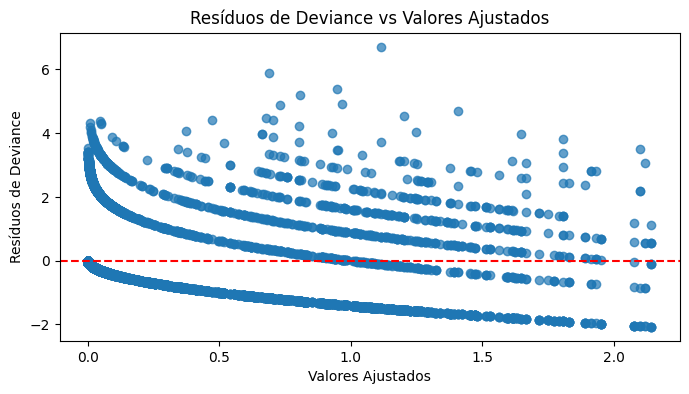

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:               183000
Model:                            GLM   Df Residuals:                   182797
Model Family:                 Poisson   Df Model:                          202
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26041.
Date:                Thu, 26 Dec 2024   Deviance:                       38283.
Time:                        11:58:09   Pearson chi2:                 1.50e+05
No. Iterations:                    27   Pseudo R-squ. (CS):            0.08782
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

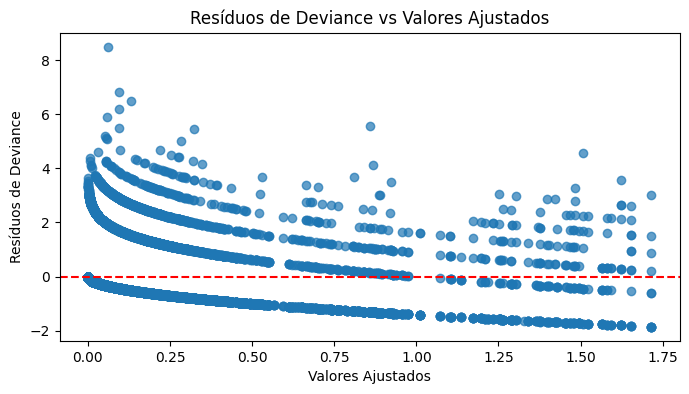

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:               183000
Model:                            GLM   Df Residuals:                   182797
Model Family:                 Poisson   Df Model:                          202
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30828.
Date:                Thu, 26 Dec 2024   Deviance:                       44734.
Time:                        12:00:18   Pearson chi2:                 1.60e+05
No. Iterations:                    27   Pseudo R-squ. (CS):             0.1268
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

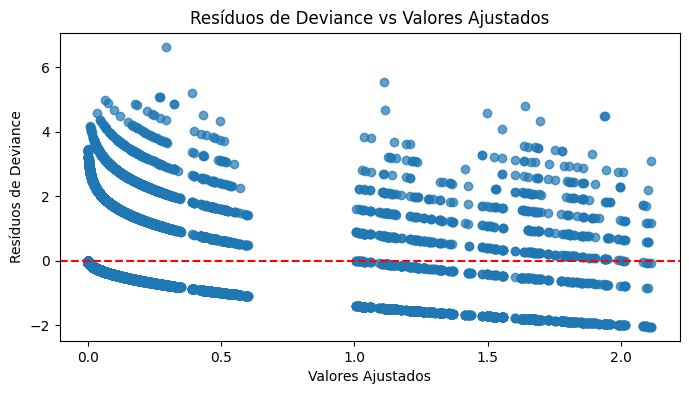

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                83448
Model:                            GLM   Df Residuals:                    83253
Model Family:                 Poisson   Df Model:                          194
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10667.
Date:                Thu, 26 Dec 2024   Deviance:                       15664.
Time:                        12:01:06   Pearson chi2:                 6.22e+04
No. Iterations:                    26   Pseudo R-squ. (CS):             0.1453
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

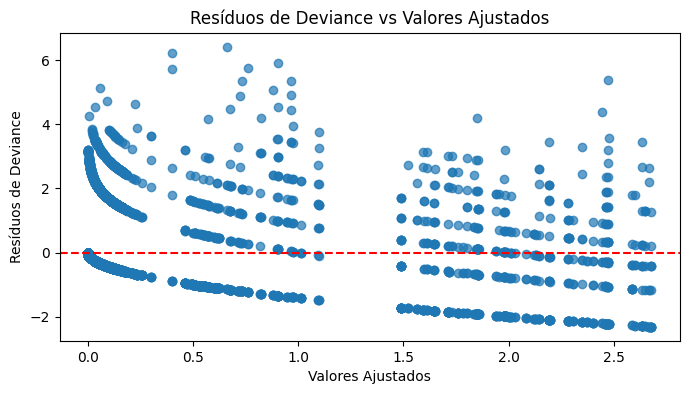

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import glm
import matplotlib.pyplot as plt

# -----------------------------------------------
# 1) Amostra reduzida (10%) para teste inicial
# -----------------------------------------------
def sample_large_dataframe(df, frac=0.1, random_state=123):
    """Amostra uma fração do DataFrame para evitar estouro de memória."""
    return df.sample(frac=frac, random_state=random_state)

# -----------------------------------------------
# 2) Processamento por chunks (evitar carregar tudo)
# -----------------------------------------------
def process_large_dataframe_in_chunks(file_path, chunksize, process_chunk_func):
    """Processa um DataFrame em chunks para economizar memória."""
    for chunk in pd.read_csv('/content/combined_calls.csv', chunksize=chunksize):
        process_chunk_func(chunk)

# -----------------------------------------------
# 3) Função principal de ajuste Poisson
# -----------------------------------------------
def fit_poisson_model(df):
    """Ajusta o modelo Poisson em uma amostra ou chunk do DataFrame."""
    # Converte colunas para categóricas para economizar memória
    for col in ['tempo', 'dia_semana']:
        df[col] = df[col].astype('category')

    # Transformação do formato wide para long (melt)
    id_vars = ['tempo', 'dia_semana']
    value_vars = [c for c in df.columns if c not in id_vars]
    df_melt = df.melt(
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='zona_categoria',
        value_name='count'
    )

    df_melt['zona_categoria'] = df_melt['zona_categoria'].astype('category')

    # Fórmula para o modelo Poisson
    formula = "count ~ C(tempo) + C(dia_semana) + C(zona_categoria)"

    # Ajuste do modelo
    model = glm(
        formula=formula,
        data=df_melt,
        family=sm.families.Poisson()
    ).fit()

    print(model.summary())

    # Resíduos de Pearson e Deviance
    resid_pearson = model.resid_pearson
    resid_deviance = model.resid_deviance

    # Soma dos quadrados dos resíduos de Pearson
    pearson_chi2 = sum(resid_pearson**2)
    df_resid = model.df_resid
    overdispersion_factor = pearson_chi2 / df_resid

    print(f"Pearson Chi2: {pearson_chi2:.2f}")
    print(f"df_resid: {df_resid}")
    print(f"Overdispersion factor: {overdispersion_factor:.2f}")

    # Gráfico de resíduos de Deviance
    plt.figure(figsize=(8, 4))
    plt.scatter(model.fittedvalues, resid_deviance, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Resíduos de Deviance vs Valores Ajustados")
    plt.xlabel("Valores Ajustados")
    plt.ylabel("Resíduos de Deviance")
    plt.show()

# -----------------------------------------------
# 4) Aplicação do script
# -----------------------------------------------
if __name__ == "__main__":
    # Simulação: Caminho para um CSV hipotético ou DataFrame carregado
    file_path = "large_dataset.csv"  # Substitua pelo caminho real
    chunksize = 10000  # Tamanho dos chunks para processamento iterativo

    # Define uma função para processar cada chunk
    def process_chunk(chunk):
        try:
            fit_poisson_model(sample_large_dataframe(chunk, frac=0.1))
        except Exception as e:
            print(f"Erro ao processar chunk: {e}")

    # Processa o DataFrame por chunks
    process_large_dataframe_in_chunks(file_path, chunksize, process_chunk)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                  100
Model:                            GLM   Df Residuals:                       83
Model Family:        NegativeBinomial   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -192.96
Date:                Thu, 26 Dec 2024   Deviance:                       33.627
Time:                        14:41:37   Pearson chi2:                     25.7
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2183
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

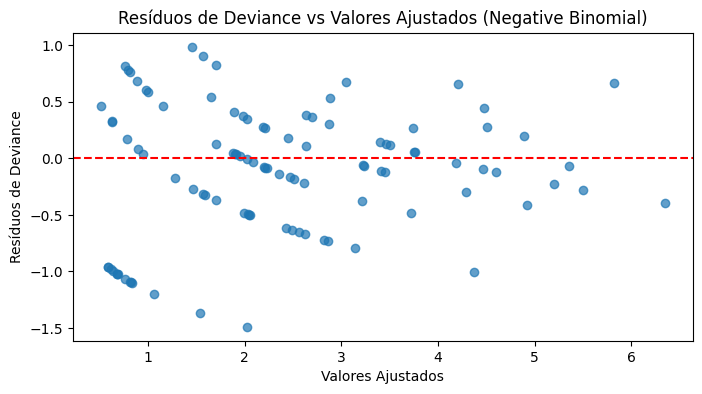

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import glm
import matplotlib.pyplot as plt

# -----------------------------------------------
# 1) Função para amostrar dataframe
# -----------------------------------------------
def sample_large_dataframe(df, frac=0.1, random_state=123):
    """
    Amostra uma fração do DataFrame para evitar estouro de memória.
    """
    return df.sample(frac=frac, random_state=random_state)

# -----------------------------------------------
# 2) Transformação e ajuste de modelo Binomial Negativa (NB)
# -----------------------------------------------
def fit_negative_binomial_model(df, alpha_value=1.0):
    """
    Ajusta um modelo de Binomial Negativa usando statsmodels GLM.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame que contém colunas 'tempo', 'dia_semana' e as colunas de contagem.
    alpha_value : float
        Parâmetro de dispersão (alpha) para a família NegativeBinomial em statsmodels.
    """

    # a) Converte colunas relevantes para categóricas (economiza memória, gera dummies internamente)
    for col in ['tempo', 'dia_semana']:
        df[col] = df[col].astype('category')

    # b) Identifica colunas de contagem (tudo que não for tempo/dia_semana)
    id_vars = ['tempo', 'dia_semana']
    value_vars = [c for c in df.columns if c not in id_vars]

    # c) Reshape wide -> long
    df_melt = df.melt(
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='zona_categoria',
        value_name='count'
    )
    df_melt['zona_categoria'] = df_melt['zona_categoria'].astype('category')

    # d) Fórmula do modelo
    formula = "count ~ C(tempo) + C(dia_semana) + C(zona_categoria)"

    # e) Ajuste do GLM com família NegativeBinomial
    #    alpha=alpha_value => dispersão (pode ser ajustado empiricamente)
    nb_family = sm.families.NegativeBinomial(alpha=alpha_value)

    model_nb = glm(
        formula=formula,
        data=df_melt,
        family=nb_family
    ).fit()

    print(model_nb.summary())

    # f) Resíduos (Pearson, Deviance)
    resid_pearson = model_nb.resid_pearson
    resid_deviance = model_nb.resid_deviance

    # g) Pearson chi2
    pearson_chi2 = sum(resid_pearson**2)
    df_resid = model_nb.df_resid
    overdispersion_factor = pearson_chi2 / df_resid if df_resid != 0 else np.nan

    print(f"Pearson Chi2: {pearson_chi2:.2f}")
    print(f"df_resid: {df_resid}")
    print(f"Fator de 'sobredispersão' (Pearson Chi2 / df): {overdispersion_factor:.2f}")


    # h) Plot de resíduos de Deviance vs valores ajustados
    plt.figure(figsize=(8,4))
    plt.scatter(model_nb.fittedvalues, resid_deviance, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Resíduos de Deviance vs Valores Ajustados (Negative Binomial)")
    plt.xlabel("Valores Ajustados")
    plt.ylabel("Resíduos de Deviance")
    plt.show()

    return model_nb

# -----------------------------------------------
# 3) Exemplo de uso
# -----------------------------------------------
if __name__ == "__main__":
    # Aqui apenas simulamos um DataFrame pequeno;
    # Substitua pelo seu DataFrame grande.
    np.random.seed(123)
    df_example = pd.DataFrame({
        'tempo': np.tile(np.arange(1, 11), 5),
        'dia_semana': np.repeat(np.arange(5), 10),
        'zonaA_cat0': np.random.poisson(2, 50),
        'zonaA_cat1': np.random.poisson(3, 50),
        'zonaB_cat0': np.random.poisson(1, 50),
        'zonaB_cat1': np.random.poisson(4, 50)
    })

    # Amostra 50% só pra ilustrar
    df_small = sample_large_dataframe(df_example, frac=0.5)

    # Ajusta NB com alpha=1.0
    model_nb = fit_negative_binomial_model(df_small, alpha_value=1.0)


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st

# Exemplo: dataframe df com colunas
# ['tempo', 'zona_77.0_categoria_2.0', 'zona_49.0_categoria_1.0', ... ]

# --------------------------------------------------
# 1) Convert 'tempo' em datetime e definir como índice
#    (caso ainda não esteja)
# --------------------------------------------------
df['tempo'] = pd.to_datetime(df['tempo'])
df = df.set_index('tempo').sort_index()

# --------------------------------------------------
# 2) Escolher um tamanho de janela p/ incrementos
#    (exemplo: 1D = 1 dia, 1H = 1 hora, etc.)
# --------------------------------------------------
window_size = '1D'  # ajuste para o que faça sentido para seu caso

# --------------------------------------------------
# 3) Agrupar (resample) para obter contagens em cada janela
#    Isso gera a soma de eventos em cada coluna ao longo de cada 'window_size'
# --------------------------------------------------
df_resampled = df.resample(window_size).sum()

# df_resampled terá algo como:
# tempo (no índice) | zona_77.0_categoria_2.0 | zona_49.0_categoria_1.0 | ...
# 2020-01-01        |  10                     |  5                       | ...
# 2020-01-02        |  13                     |  6                       | ...
# ...
# Cada linha corresponde ao total de eventos naquela janela de tempo.

# --------------------------------------------------
# 4) Calcular correlações entre colunas
# --------------------------------------------------
corr_matrix = df_resampled.corr()
print("Correlation matrix among processes:")
print(corr_matrix)

# OU fazer teste de Pearson para cada par (significância)
columns = df_resampled.columns
n = len(columns)

p_values = pd.DataFrame(np.zeros((n, n)), columns=columns, index=columns)
r_values = pd.DataFrame(np.zeros((n, n)), columns=columns, index=columns)

for i in range(n):
    for j in range(i, n):
        col_i = columns[i]
        col_j = columns[j]
        # Retirar NaNs eventualmente
        valid_data = df_resampled[[col_i, col_j]].dropna()
        if len(valid_data) > 2:
            r, p = st.pearsonr(valid_data[col_i], valid_data[col_j])
            r_values.loc[col_i, col_j] = r
            r_values.loc[col_j, col_i] = r
            p_values.loc[col_i, col_j] = p
            p_values.loc[col_j, col_i] = p
        else:
            # caso não tenha dados suficientes
            r_values.loc[col_i, col_j] = np.nan
            p_values.loc[col_i, col_j] = np.nan
            r_values.loc[col_j, col_i] = np.nan
            p_values.loc[col_j, col_i] = np.nan

print("\nPearson R-values:")
print(r_values)
print("\nPearson p-values:")
print(p_values)

# Análise:
# - Se os coeficientes de correlação (r) forem próximos de zero
#   e os p-valores grandes (> 0.05, por ex.), indica que não há
#   evidência estatística de correlação entre aqueles processos.
#
# - Se você encontra correlações significativas para um par
#   (ou vários pares), isso sugere que eles NÃO são independentes.


Correlation matrix among processes:
                         dia_semana  zona_77.0_categoria_2.0  \
dia_semana                      NaN                      NaN   
zona_77.0_categoria_2.0         NaN                      NaN   
zona_77.0_categoria_0.0         NaN                      NaN   
zona_77.0_categoria_1.0         NaN                      NaN   
zona_49.0_categoria_0.0         NaN                      NaN   
...                             ...                      ...   
zona_75.0_categoria_2.0         NaN                      NaN   
zona_75.0_categoria_1.0         NaN                      NaN   
zona_52.0_categoria_0.0         NaN                      NaN   
zona_52.0_categoria_2.0         NaN                      NaN   
zona_52.0_categoria_1.0         NaN                      NaN   

                         zona_77.0_categoria_0.0  zona_77.0_categoria_1.0  \
dia_semana                                   NaN                      NaN   
zona_77.0_categoria_2.0                  

In [ ]:
import math
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import glm
import matplotlib.pyplot as plt

def fit_poisson_model(df, chunk_idx):
    """
    Ajusta o modelo Poisson para o chunk de dados e exibe
    resultados básicos, incluindo análise de resíduos.
    """
    # ----------------------------------------
    # 1) Converter colunas que devem ser categóricas
    #    (ajuste conforme suas colunas reais)
    # ----------------------------------------
    # Exemplo: supondo que no DF haja 'tempo' e 'dia_semana'
    for col in ['tempo', 'dia_semana']:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # ----------------------------------------
    # 2) Identificar colunas de zonas/categorias
    #    Aqui supomos que são todas as colunas que não sejam tempo/dia_semana
    # ----------------------------------------
    id_vars = ['tempo', 'dia_semana']
    value_vars = [c for c in df.columns if c not in id_vars]

    # Se não houver nenhuma 'zona_categoria', ajuste essa lista
    if not value_vars:
        print(f'Chunk {chunk_idx}: não há colunas de zona/categoria para melt.')
        return

    # ----------------------------------------
    # 3) Transformar para formato longo (melt)
    #    (tempo, dia_semana, zona_categoria, count)
    # ----------------------------------------
    df_melt = df.melt(
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='zona_categoria',
        value_name='count'
    )

    df_melt['zona_categoria'] = df_melt['zona_categoria'].astype('category')

    # ----------------------------------------
    # 4) Ajustar o modelo Poisson
    # ----------------------------------------
    # Exemplo de fórmula (ajuste para as colunas que você tem):
    formula = "count ~ C(tempo) + C(dia_semana) + C(zona_categoria)"

    model = glm(formula=formula, data=df_melt, family=sm.families.Poisson()).fit()

    print(f"\n=== RESULTADOS DO CHUNK {chunk_idx} ===")
    print(model.summary())

    # ----------------------------------------
    # 5) Análise de Resíduos
    # ----------------------------------------
    resid_pearson = model.resid_pearson
    resid_deviance = model.resid_deviance

    pearson_chi2 = sum(resid_pearson**2)
    df_resid = model.df_resid
    overdispersion_factor = pearson_chi2 / df_resid

    print(f"Pearson Chi2: {pearson_chi2:.2f}")
    print(f"df_resid: {df_resid}")
    print(f"Fator de Sobredispersão (Pearson Chi2/df): {overdispersion_factor:.2f}")

    # Plot simples: Resíduos de Deviance vs. Valores Ajustados
    plt.figure(figsize=(7, 4))
    plt.scatter(model.fittedvalues, resid_deviance, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Valores Ajustados")
    plt.ylabel("Resíduos de Deviance")
    plt.title(f"Chunk {chunk_idx}: Resíduos vs Ajustados")
    plt.show()


if __name__ == "__main__":
    # ----------------------------------------
    # 1) Descobrir número total de linhas (excluindo cabeçalho)
    # ----------------------------------------
    file_path = "meu_dataset_grande.csv"

    with open(file_path, 'r', encoding='utf-8') as f:
        # Conta linhas (menos 1 para ignorar o header)
        total_lines = sum(1 for _ in f) - 1

    print(f"Total de linhas (sem header): {total_lines}")

    # ----------------------------------------
    # 2) Dividir em ~10 blocos
    #    De modo que, ao final, tenhamos percorrido 100% do DF
    # ----------------------------------------
    chunksize = math.ceil(total_lines / 10)
    print(f"Chunksize ~ {chunksize} (cada chunk ~ 10% dos dados)")

    # ----------------------------------------
    # 3) Ler o CSV em 10 blocos e ajustar o modelo em cada
    # ----------------------------------------
    chunk_idx = 0
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunk_idx += 1
        print(f"\n[Processando Chunk {chunk_idx}] Tamanho do chunk: {len(chunk)}")
        # Chame a função de ajuste no chunk
        fit_poisson_model(chunk, chunk_idx)

        # Se chegar no 10º chunk, podemos parar
        # caso o arquivo tenha algum resíduo a mais:
        if chunk_idx == 10:
            break

    print("\nFim do processamento.")


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import poisson
import itertools

def em_algorithm_single(S, Y, p_true, max_iter=100, tol=1e-6):
    n = Y.shape[0]
    lambda_est = np.ones(n)
    lambda_history = [lambda_est.copy()]
    log_likelihood_history = []

    def log_likelihood(lambda_est):
        X_conditional_mean = np.array([
            S * (p_true[i] * lambda_est[i]) / np.sum(p_true * lambda_est)
            for i in range(n)
        ])
        return np.sum([
            np.sum(X_conditional_mean[i] * np.log(p_true[i] * lambda_est[i])
                   - p_true[i] * lambda_est[i])
            + np.sum(Y[i] * np.log((1 - p_true[i]) * lambda_est[i])
                   - (1 - p_true[i]) * lambda_est[i])
            for i in range(n)
        ])

    for _ in range(max_iter):
        X_conditional_mean = np.array([
            S * (p_true[i] * lambda_est[i]) / np.sum(p_true * lambda_est)
            for i in range(n)
        ])

        lambda_new = np.array([
            np.mean(X_conditional_mean[i] + Y[i])
            for i in range(n)
        ])

        lambda_history.append(lambda_new.copy())

        log_likelihood_value = log_likelihood(lambda_new)
        log_likelihood_history.append(log_likelihood_value)

        if np.all(np.abs(lambda_new - lambda_est) < tol):
            break

        lambda_est = lambda_new

    return lambda_est, lambda_history, log_likelihood_history

results = []
empirical_means = []

for (tempo, dia_semana), group in df.groupby(['tempo', 'dia_semana']):
    S = group[[col for col in group.columns if 'zona_77' in col]].sum(axis=1).values
    Y_columns = [col for col in group.columns if 'zona_77' not in col and 'categoria' in col]

    for cat in ['categoria_0.0', 'categoria_1.0', 'categoria_2.0']:
        Y = group[[col for col in Y_columns if cat in col]].values.T

        p_true = np.random.uniform(0.3, 0.3, Y.shape[0])

        lambda_est, lambda_history, log_likelihood_history = em_algorithm_single(S, Y, p_true)

        for idx, zona in enumerate([col.split('_')[1] for col in Y_columns if cat in col]):
            results.append({
                'tempo': tempo,
                'dia_semana': dia_semana,
                'categoria': cat,
                'zona': zona,
                'lambda_est': lambda_est[idx],
                'log_likelihood': log_likelihood_history[-1]
            })

        for idx, zona in enumerate([col.split('_')[1] for col in Y_columns if cat in col]):
            empirical_means.append({
                'tempo': tempo,
                'dia_semana': dia_semana,
                'categoria': cat,
                'zona': zona,
                'empirical_mean': Y[idx].mean()
            })

results_df = pd.DataFrame(results)
empirical_means_df = pd.DataFrame(empirical_means)

print(results_df.head())
print(empirical_means_df.head())


   tempo  dia_semana      categoria  zona    lambda_est  log_likelihood
0      1           1  categoria_0.0  49.0  4.762225e-01    -2212.106299
1      1           1  categoria_0.0  58.0  2.948046e-01    -2212.106299
2      1           1  categoria_0.0  35.0  4.740410e-07    -2212.106299
3      1           1  categoria_0.0  64.0  9.070943e-02    -2212.106299
4      1           1  categoria_0.0  21.0  9.070943e-02    -2212.106299
   tempo  dia_semana      categoria  zona  empirical_mean
0      1           1  categoria_0.0  49.0        0.203883
1      1           1  categoria_0.0  58.0        0.126214
2      1           1  categoria_0.0  35.0        0.000000
3      1           1  categoria_0.0  64.0        0.038835
4      1           1  categoria_0.0  21.0        0.038835


In [ ]:
results_df

,tempo,dia_semana,categoria,zona,lambda_est,log_likelihood
0,1,1,categoria_0.0,49.0,4.762225e-01,-2212.106299
1,1,1,categoria_0.0,58.0,2.948046e-01,-2212.106299
2,1,1,categoria_0.0,35.0,4.740410e-07,-2212.106299
3,1,1,categoria_0.0,64.0,9.070943e-02,-2212.106299
4,1,1,categoria_0.0,21.0,9.070943e-02,-2212.106299
...,...,...,...,...,...,...
60475,48,7,categoria_2.0,2.0,6.181230e-02,-1905.273035
60476,48,7,categoria_2.0,41.0,6.181230e-02,-1905.273035
60477,48,7,categoria_2.0,10.0,6.181230e-02,-1905.273035
60478,48,7,categoria_2.0,75.0,6.181230e-02,-1905.273035


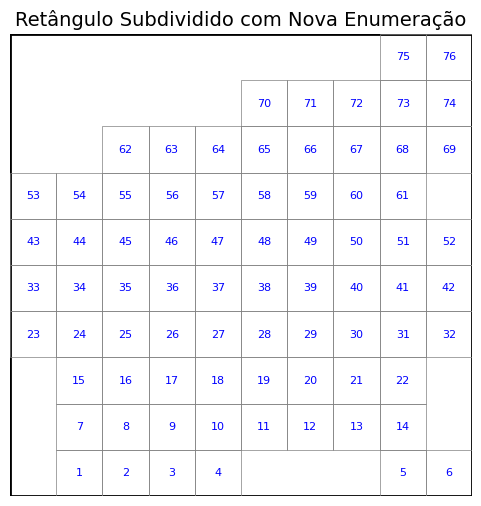

In [ ]:
def plot_rectangle_with_removed_squares(width, height, sub_width, sub_height, remover_indices):
    """
    Plota um retângulo subdividido em sub-retângulos com quadrados removidos e contagem refeita.

    :param width: Largura do retângulo principal.
    :param height: Altura do retângulo principal.
    :param sub_width: Largura dos sub-retângulos.
    :param sub_height: Altura dos sub-retângulos.
    :param remover_indices: Lista de índices dos sub-retângulos a serem removidos.
    """
    # Configurações do plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.set_aspect('equal')

    # Adicionando o retângulo principal
    main_rect = patches.Rectangle((0, 0), width, height, edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(main_rect)

    # Adicionando os retângulos subdivididos (10x10) com nova enumeração
    new_count = 1
    count = 1
    for y in range(0, height, sub_height):  # Iteração de baixo para cima
        for x in range(0, width, sub_width):  # Iteração da esquerda para a direita
            if count not in remover_indices:  # Apenas adicionar os quadrados que não estão na lista
                sub_rect = patches.Rectangle((x, y), sub_width, sub_height, edgecolor='gray', facecolor='none', linewidth=0.5)
                ax.add_patch(sub_rect)
                # Adicionando a nova numeração no centro de cada quadrado
                ax.text(x + sub_width / 2, y + sub_height / 2, str(new_count), color='blue',
                        ha='center', va='center', fontsize=8)
                new_count += 1
            count += 1

    # Remoção de eixos e título
    ax.set_title("Retângulo Subdividido com Nova Enumeração", fontsize=14)
    ax.axis('off')

    # Mostrar o gráfico
    plt.show()


# Parâmetros e chamada da função
remover_indices = [1, 11,20,30, 21,70, 71, 72,81]+ list(range(91, 99))+ list(range(82, 86)) + list(range(6, 9))
plot_rectangle_with_removed_squares(100, 100, 10, 10, remover_indices)


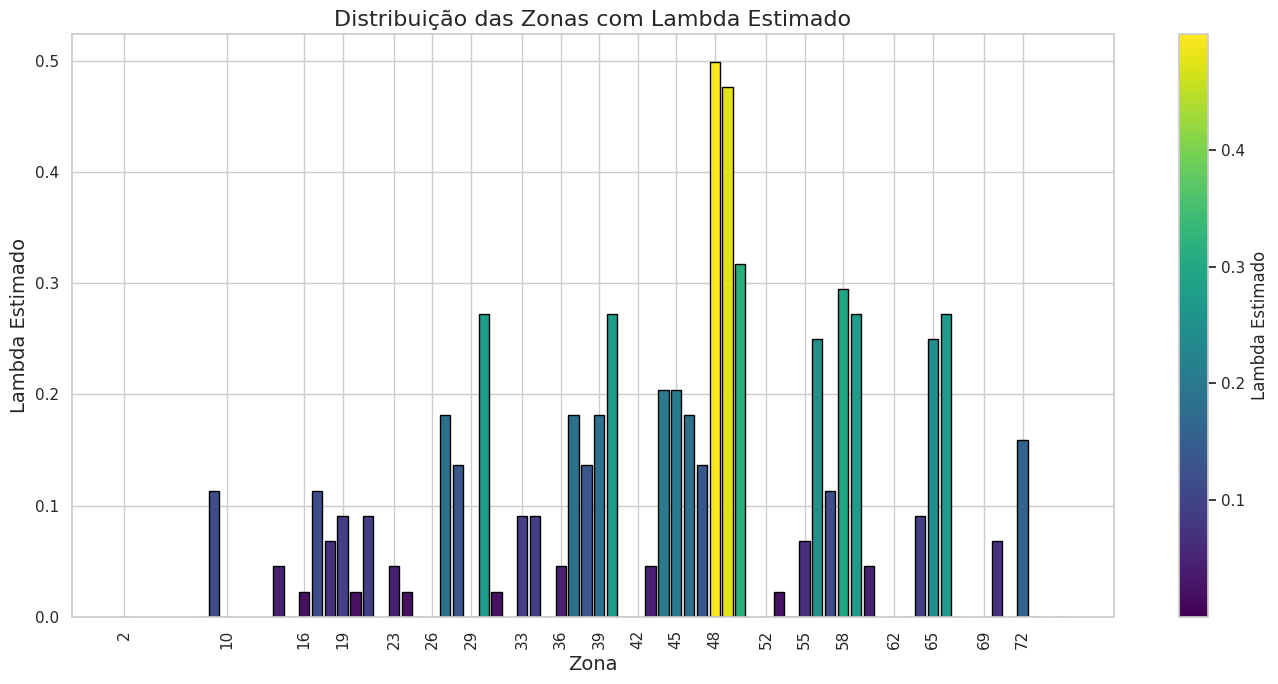

In [ ]:
# Importar as Bibliotecas Necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Configurar o Estilo do Seaborn (Opcional)
sns.set(style="whitegrid")

def main():
    # Passo 1: Carregar os Dados
    # ---------------------------------
    # Substitua 'seu_arquivo.csv' pelo caminho do seu arquivo de dados.
    # Se os dados já estiverem carregados em um DataFrame, pule esta etapa.
    df= df_filtered
    filtro = (df['tempo'] == 1) & (df['dia_semana'] == 1) & (df['categoria'] == 'categoria_0.0')
    df_filtrado = df[filtro].copy()  # Usar .copy() para evitar o SettingWithCopyWarning

    # Verificar se o DataFrame filtrado está vazio
    if df_filtrado.empty:
        print("Nenhum dado corresponde aos critérios de filtragem.")
        return

    # Passo 3: Converter a Coluna 'zona' para Inteiro
    # ---------------------------------
    # Remove possíveis espaços ou caracteres indesejados e converte para inteiro
    df_filtrado['zona'] = df_filtrado['zona'].astype(str).str.strip().astype(int)

    # Passo 4: Agrupar os Dados por 'zona' e Calcular a Média de 'lambda_est'
    # ---------------------------------
    df_grouped = df_filtrado.groupby('zona', as_index=False)['lambda_est'].mean()

    # Passo 5: Configurar o Mapa de Cores e Normalização
    # ---------------------------------
    cmap = plt.cm.viridis  # Escolha o colormap desejado
    norm = mpl.colors.Normalize(vmin=df_grouped['lambda_est'].min(), vmax=df_grouped['lambda_est'].max())

    # Passo 6: Criar o Gráfico de Barras com Cores Representando 'lambda_est'
    # ---------------------------------
    fig, ax = plt.subplots(figsize=(14, 7))

    # Mapear as cores para cada barra com base em 'lambda_est'
    colors = cmap(norm(df_grouped['lambda_est']))

    # Criar o gráfico de barras
    bars = ax.bar(df_grouped['zona'], df_grouped['lambda_est'], color=colors, edgecolor='black')

    # Personalizar o Gráfico
    ax.set_xlabel('Zona', fontsize=14)
    ax.set_ylabel('Lambda Estimado', fontsize=14)
    ax.set_title('Distribuição das Zonas com Lambda Estimado (dia 1, cat 1, t 1)', fontsize=16)

    # Ajustar os ticks do eixo x
    num_zonas = len(df_grouped['zona'])
    if num_zonas > 20:
        # Mostrar a cada 5 zonas para evitar sobreposição
        step = max(1, num_zonas // 20)
        ax.set_xticks(df_grouped['zona'][::step])
        ax.set_xticklabels(df_grouped['zona'][::step], rotation=90)
    else:
        ax.set_xticks(df_grouped['zona'])
        ax.set_xticklabels(df_grouped['zona'], rotation=90)

    # Adicionar a Barra de Cores (Colorbar)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Necessário para a barra de cores
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Lambda Estimado', fontsize=12)

    # Melhorar o Layout
    plt.tight_layout()

    # Exibir o Gráfico
    plt.show()

if __name__ == "__main__":
    main()


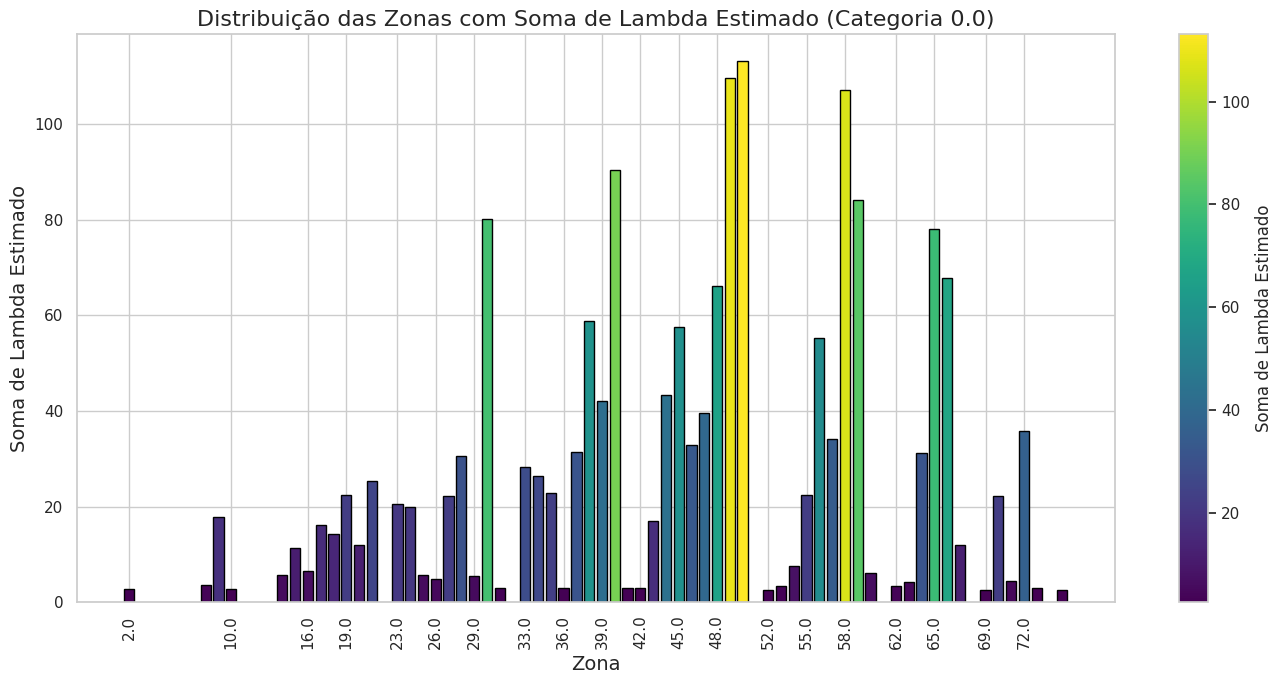

In [ ]:
# Importar as Bibliotecas Necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Configurar o Estilo do Seaborn (Opcional)
sns.set(style="whitegrid")

def main():


    # Passo 2: Filtrar o DataFrame
    # ---------------------------------
    # Filtra as linhas onde categoria='categoria_0.0'
    filtro = df['categoria'] == 'categoria_0.0'
    df_filtrado = df[filtro].copy()  # Usar .copy() para evitar o SettingWithCopyWarning

    # Verificar se o DataFrame filtrado está vazio
    if df_filtrado.empty:
        print("Nenhum dado corresponde aos critérios de filtragem (categoria='categoria_0.0').")
        return

    # Passo 3: Converter a Coluna 'zona' para Inteiro
    # ---------------------------------
    # Remove possíveis espaços ou caracteres indesejados e converte para inteiro


    # Passo 4: Agrupar os Dados por 'zona' e Calcular a Soma de 'lambda_est'
    # ---------------------------------
    df_grouped = df_filtrado.groupby('zona', as_index=False)['lambda_est'].sum()

    # Verificar se o agrupamento resultou em dados
    if df_grouped.empty:
        print("Após o agrupamento, não há dados para plotar.")
        return

    # Passo 5: Configurar o Mapa de Cores e Normalização
    # ---------------------------------
    cmap = plt.cm.viridis  # Escolha o colormap desejado
    norm = mpl.colors.Normalize(vmin=df_grouped['lambda_est'].min(), vmax=df_grouped['lambda_est'].max())

    # Passo 6: Criar o Gráfico de Barras com Cores Representando 'lambda_est'
    # ---------------------------------
    fig, ax = plt.subplots(figsize=(14, 7))

    # Mapear as cores para cada barra com base em 'lambda_est'
    colors = cmap(norm(df_grouped['lambda_est']))

    # Criar o gráfico de barras
    bars = ax.bar(df_grouped['zona'], df_grouped['lambda_est'], color=colors, edgecolor='black')

    # Personalizar o Gráfico
    ax.set_xlabel('Zona', fontsize=14)
    ax.set_ylabel('Soma de Lambda Estimado', fontsize=14)
    ax.set_title('Distribuição das Zonas com Soma de Lambda Estimado (Categoria 0.0)', fontsize=16)

    # Ajustar os ticks do eixo x
    num_zonas = len(df_grouped['zona'])
    if num_zonas > 20:
        # Mostrar a cada 5 zonas para evitar sobreposição
        step = max(1, num_zonas // 20)
        ax.set_xticks(df_grouped['zona'][::step])
        ax.set_xticklabels(df_grouped['zona'][::step], rotation=90)
    else:
        ax.set_xticks(df_grouped['zona'])
        ax.set_xticklabels(df_grouped['zona'], rotation=90)

    # Adicionar a Barra de Cores (Colorbar)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Necessário para a barra de cores
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Soma de Lambda Estimado', fontsize=12)

    # Melhorar o Layout
    plt.tight_layout()

    # Exibir o Gráfico
    plt.show()

if __name__ == "__main__":
    main()


Índice de Gini: 0.5202


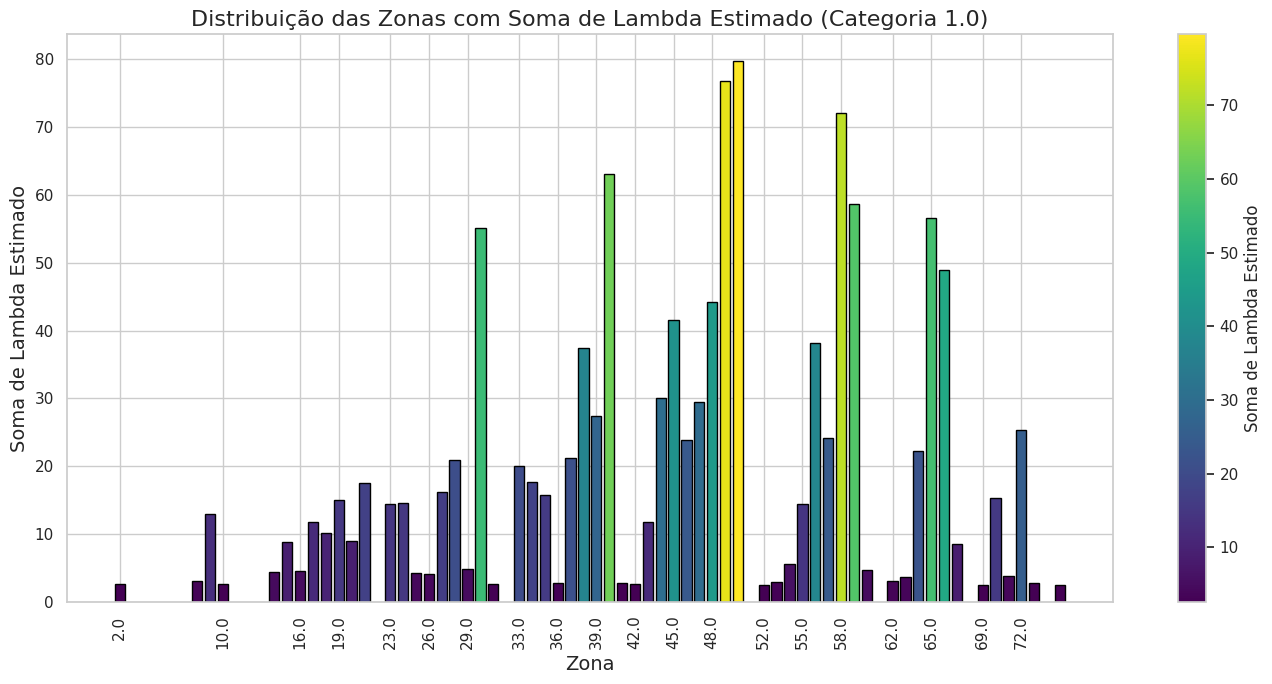

In [ ]:
# Importar as Bibliotecas Necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Configurar o Estilo do Seaborn (Opcional)
sns.set(style="whitegrid")

def main():


    # Passo 2: Filtrar o DataFrame
    # ---------------------------------
    # Filtra as linhas onde categoria='categoria_0.0'
    filtro = df['categoria'] == 'categoria_1.0'
    df_filtrado = df[filtro].copy()  # Usar .copy() para evitar o SettingWithCopyWarning

    # Verificar se o DataFrame filtrado está vazio
    if df_filtrado.empty:
        print("Nenhum dado corresponde aos critérios de filtragem (categoria='categoria_0.0').")
        return

    # Passo 3: Converter a Coluna 'zona' para Inteiro
    # ---------------------------------
    # Remove possíveis espaços ou caracteres indesejados e converte para inteiro


    # Passo 4: Agrupar os Dados por 'zona' e Calcular a Soma de 'lambda_est'
    # ---------------------------------
    df_grouped = df_filtrado.groupby('zona', as_index=False)['lambda_est'].sum()

    # Verificar se o agrupamento resultou em dados
    if df_grouped.empty:
        print("Após o agrupamento, não há dados para plotar.")
        return
    valores = df_grouped['lambda_est'].values
    indice_gini = calcular_indice_gini(valores)
    print(f"Índice de Gini: {indice_gini:.4f}")
    # Passo 5: Configurar o Mapa de Cores e Normalização
    # ---------------------------------
    cmap = plt.cm.viridis  # Escolha o colormap desejado
    norm = mpl.colors.Normalize(vmin=df_grouped['lambda_est'].min(), vmax=df_grouped['lambda_est'].max())

    # Passo 6: Criar o Gráfico de Barras com Cores Representando 'lambda_est'
    # ---------------------------------
    fig, ax = plt.subplots(figsize=(14, 7))

    # Mapear as cores para cada barra com base em 'lambda_est'
    colors = cmap(norm(df_grouped['lambda_est']))

    # Criar o gráfico de barras
    bars = ax.bar(df_grouped['zona'], df_grouped['lambda_est'], color=colors, edgecolor='black')

    # Personalizar o Gráfico
    ax.set_xlabel('Zona', fontsize=14)
    ax.set_ylabel('Soma de Lambda Estimado', fontsize=14)
    ax.set_title('Distribuição das Zonas com Soma de Lambda Estimado (Categoria 1.0)', fontsize=16)

    # Ajustar os ticks do eixo x
    num_zonas = len(df_grouped['zona'])
    if num_zonas > 20:
        # Mostrar a cada 5 zonas para evitar sobreposição
        step = max(1, num_zonas // 20)
        ax.set_xticks(df_grouped['zona'][::step])
        ax.set_xticklabels(df_grouped['zona'][::step], rotation=90)
    else:
        ax.set_xticks(df_grouped['zona'])
        ax.set_xticklabels(df_grouped['zona'], rotation=90)

    # Adicionar a Barra de Cores (Colorbar)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Necessário para a barra de cores
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Soma de Lambda Estimado', fontsize=12)

    # Melhorar o Layout
    plt.tight_layout()

    # Exibir o Gráfico
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
empirical_means_df

,tempo,dia_semana,categoria,zona,empirical_mean
0,1,1,categoria_0.0,49.0,0.203883
1,1,1,categoria_0.0,58.0,0.126214
2,1,1,categoria_0.0,35.0,0.000000
3,1,1,categoria_0.0,64.0,0.038835
4,1,1,categoria_0.0,21.0,0.038835
...,...,...,...,...,...
60475,48,7,categoria_2.0,2.0,0.000000
60476,48,7,categoria_2.0,41.0,0.000000
60477,48,7,categoria_2.0,10.0,0.000000
60478,48,7,categoria_2.0,75.0,0.000000


Índice de Gini: 0.5954


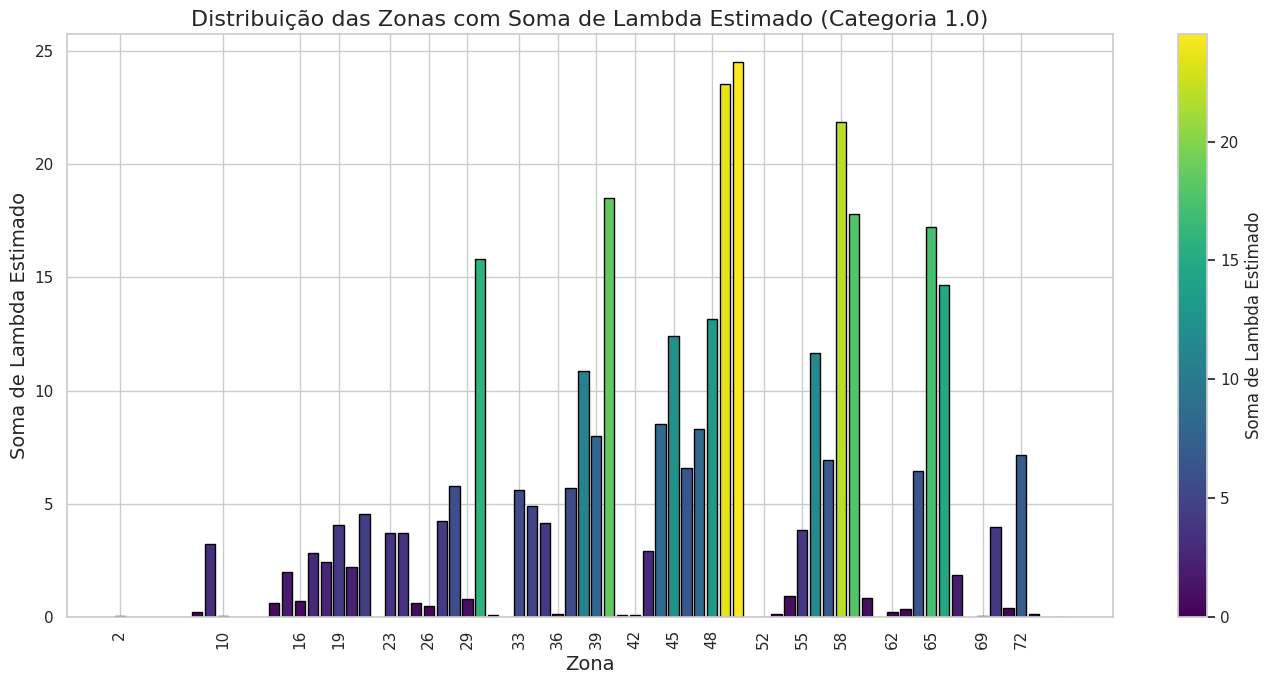

In [ ]:
# Importar as Bibliotecas Necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Configurar o Estilo do Seaborn (Opcional)
sns.set(style="whitegrid")

def calcular_indice_gini(valores):
    """
    Calcula o índice de Gini para uma lista de valores.
    """
    # Ordenar os valores em ordem crescente
    valores = np.sort(valores)

    # Calcular os índices acumulativos
    n = len(valores)
    acumulado = np.cumsum(valores)

    # Soma acumulada normalizada
    acumulado_normalizado = acumulado / acumulado[-1]

    # Calcular o índice de Gini usando a fórmula
    G = 1 - (2 / n) * np.sum((n - np.arange(1, n + 1) + 0.5) * (valores / acumulado[-1]))
    return G
def main():


    # Passo 2: Filtrar o DataFrame
    # ---------------------------------
    # Filtra as linhas onde categoria='categoria_0.0'
    df= empirical_means_df
    df["zona"]=pd.to_numeric(df['zona'], errors='coerce')
    df=df.dropna(subset=['zona'])
    df['zona'] = df['zona'].astype(int)
    filtro = df['categoria'] == 'categoria_1.0'
    df_filtrado = df[filtro].copy()  # Usar .copy() para evitar o SettingWithCopyWarning

    # Verificar se o DataFrame filtrado está vazio
    if df_filtrado.empty:
        print("Nenhum dado corresponde aos critérios de filtragem (categoria='categoria_0.0').")
        return

    # Passo 3: Converter a Coluna 'zona' para Inteiro
    # ---------------------------------
    # Remove possíveis espaços ou caracteres indesejados e converte para inteiro


    # Passo 4: Agrupar os Dados por 'zona' e Calcular a Soma de 'lambda_est'
    # ---------------------------------
    df_grouped = df_filtrado.groupby('zona', as_index=False)['empirical_mean'].sum()

    # Verificar se o agrupamento resultou em dados
    if df_grouped.empty:
        print("Após o agrupamento, não há dados para plotar.")
        return
    # Passo 5: Calcular o Índice de Gini
    valores = df_grouped['empirical_mean'].values
    indice_gini = calcular_indice_gini(valores)
    print(f"Índice de Gini: {indice_gini:.4f}")
    # Passo 5: Configurar o Mapa de Cores e Normalização
    # ---------------------------------
    cmap = plt.cm.viridis  # Escolha o colormap desejado
    norm = mpl.colors.Normalize(vmin=df_grouped['empirical_mean'].min(), vmax=df_grouped['empirical_mean'].max())

    # Passo 6: Criar o Gráfico de Barras com Cores Representando 'lambda_est'
    # ---------------------------------
    fig, ax = plt.subplots(figsize=(14, 7))

    # Mapear as cores para cada barra com base em 'lambda_est'
    colors = cmap(norm(df_grouped['empirical_mean']))

    # Criar o gráfico de barras
    bars = ax.bar(df_grouped['zona'], df_grouped['empirical_mean'], color=colors, edgecolor='black')

    # Personalizar o Gráfico
    ax.set_xlabel('Zona', fontsize=14)
    ax.set_ylabel('Soma de Lambda Estimado', fontsize=14)
    ax.set_title('Distribuição das Zonas com Soma de Lambda Estimado (Categoria 1.0)', fontsize=16)

    # Ajustar os ticks do eixo x
    num_zonas = len(df_grouped['zona'])
    if num_zonas > 20:
        # Mostrar a cada 5 zonas para evitar sobreposição
        step = max(1, num_zonas // 20)
        ax.set_xticks(df_grouped['zona'][::step])
        ax.set_xticklabels(df_grouped['zona'][::step], rotation=90)
    else:
        ax.set_xticks(df_grouped['zona'])
        ax.set_xticklabels(df_grouped['zona'], rotation=90)

    # Adicionar a Barra de Cores (Colorbar)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Necessário para a barra de cores
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Soma de Lambda Estimado', fontsize=12)

    # Melhorar o Layout
    plt.tight_layout()

    # Exibir o Gráfico
    plt.show()

if __name__ == "__main__":
    main()


Zonas selecionadas para estações de ambulância: [49, 58, 39, 65, 45]
Soma total de Lambda Estimado coberta: 1016.2505


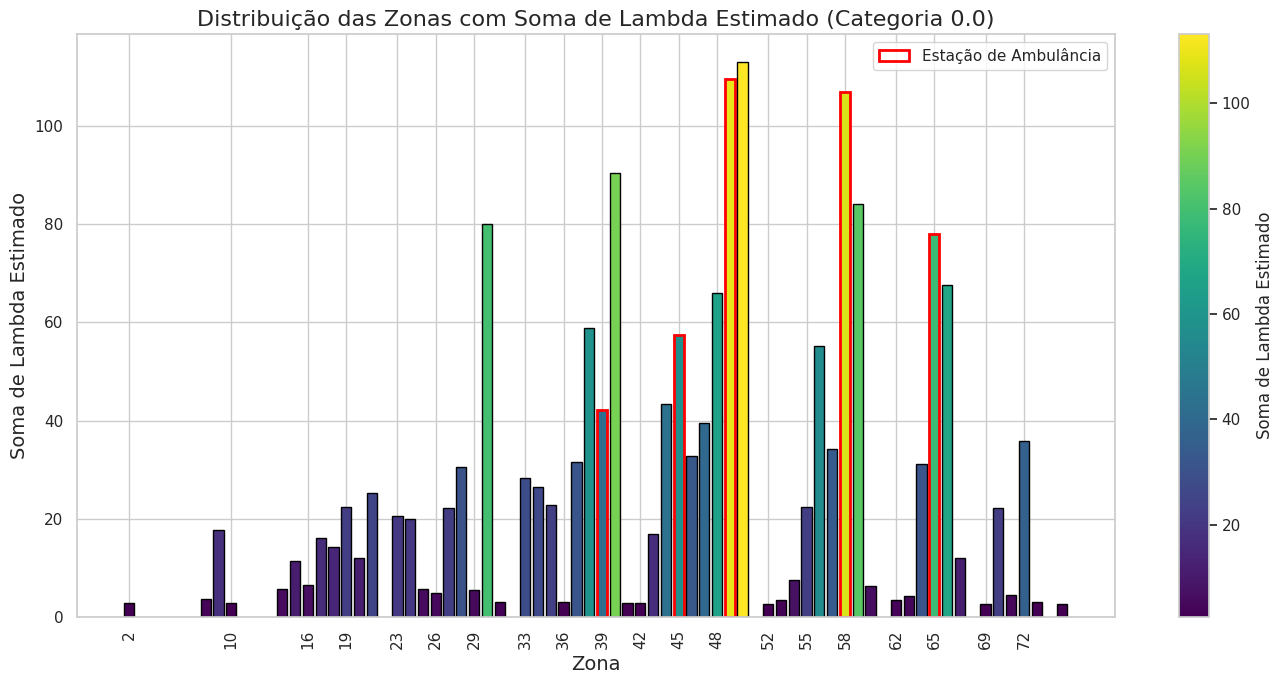

In [ ]:
# Importar as Bibliotecas Necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Configurar o Estilo do Seaborn (Opcional)
sns.set(style="whitegrid")

def definir_adjacencia(zonas):
    """
    Define a adjacência das zonas assumindo que zonas com números consecutivos são adjacentes.
    """
    adjacentes = {}
    for zona in zonas:
        adj = set()
        if zona - 1 in zonas:
            adj.add(zona - 1)
        if zona + 1 in zonas:
            adj.add(zona + 1)
        adjacentes[zona] = adj
    return adjacentes

def algoritmo_guloso_set_cover(zonas, adjacentes, lambda_est, num_estacoes):
    """
    Implementa um algoritmo guloso para resolver o problema de cobertura de conjuntos.

    Parameters:
    - zonas: Lista de zonas disponíveis.
    - adjacentes: Dicionário definindo as zonas adjacentes para cada zona.
    - lambda_est: Dicionário com a soma de lambda_est por zona.
    - num_estacoes: Número de estações de ambulância a serem colocadas.

    Returns:
    - estacoes_selecionadas: Lista de zonas selecionadas para estações.
    - cobertura_total: Soma de lambda_est cobertos pelas estações.
    """
    estacoes_selecionadas = []
    cobertura_coberta = set()
    cobertura_total = 0

    for _ in range(num_estacoes):
        melhor_zona = None
        melhor_cobertura = 0
        # Iterar sobre todas as zonas não selecionadas
        for zona in zonas:
            if zona in estacoes_selecionadas:
                continue
            # Zonas que seriam cobertas se uma estação fosse colocada nesta zona
            zonas_cobertas = set([zona]) | adjacentes[zona]
            # Zonas efetivamente cobertas que ainda não estão cobertas
            zonas_novas_cobertas = zonas_cobertas - cobertura_coberta
            # Soma de lambda_est das zonas cobertas
            soma_novas = sum([lambda_est[z] for z in zonas_novas_cobertas])
            if soma_novas > melhor_cobertura:
                melhor_cobertura = soma_novas
                melhor_zona = zona
        if melhor_zona is None:
            # Nenhuma zona adicional pode ser coberta
            break
        estacoes_selecionadas.append(melhor_zona)
        zonas_cobertas = set([melhor_zona]) | adjacentes[melhor_zona]
        cobertura_coberta.update(zonas_cobertas)
        cobertura_total += sum([lambda_est[z] for z in zonas_cobertas])

    return estacoes_selecionadas, cobertura_total

def plot_cobertura(df_grouped, estacoes_selecionadas):
    """
    Plota o gráfico de barras com as zonas selecionadas destacadas.
    """
    # Configurar o Mapa de Cores e Normalização
    cmap = plt.cm.viridis  # Escolha o colormap desejado
    norm = mpl.colors.Normalize(vmin=df_grouped['lambda_est'].min(), vmax=df_grouped['lambda_est'].max())

    # Criar o Gráfico de Barras
    fig, ax = plt.subplots(figsize=(14, 7))
    colors = cmap(norm(df_grouped['lambda_est']))
    bars = ax.bar(df_grouped['zona'], df_grouped['lambda_est'], color=colors, edgecolor='black')

    # Destacar as zonas com estações de ambulância
    for barra, zona in zip(bars, df_grouped['zona']):
        if zona in estacoes_selecionadas:
            barra.set_edgecolor('red')
            barra.set_linewidth(2)

    # Personalizar o Gráfico
    ax.set_xlabel('Zona', fontsize=14)
    ax.set_ylabel('Soma de Lambda Estimado', fontsize=14)
    ax.set_title('Distribuição das Zonas com Soma de Lambda Estimado (Categoria 0.0)', fontsize=16)

    # Ajustar os ticks do eixo x
    num_zonas = len(df_grouped['zona'])
    if num_zonas > 20:
        step = max(1, num_zonas // 20)
        ax.set_xticks(df_grouped['zona'][::step])
        ax.set_xticklabels(df_grouped['zona'][::step], rotation=90)
    else:
        ax.set_xticks(df_grouped['zona'])
        ax.set_xticklabels(df_grouped['zona'], rotation=90)

    # Adicionar a Barra de Cores (Colorbar)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Soma de Lambda Estimado', fontsize=12)

    # Criar uma legenda para as estações de ambulância
    from matplotlib.patches import Patch
    legenda = [Patch(facecolor='none', edgecolor='red', linewidth=2, label='Estação de Ambulância')]
    ax.legend(handles=legenda, loc='upper right')

    # Melhorar o Layout
    plt.tight_layout()

    # Exibir o Gráfico
    plt.show()

def main():

    # ---------------------------------
    # Filtra as linhas onde categoria='categoria_0.0'
    df=results_df
    df["zona"]=pd.to_numeric(df['zona'], errors='coerce')
    df=df.dropna(subset=['zona'])
    df['zona'] = df['zona'].astype(int)
    filtro = df['categoria'] == 'categoria_0.0'
    df_filtrado = df[filtro].copy()

    # Verificar se o DataFrame filtrado está vazio
    if df_filtrado.empty:
        print("Nenhum dado corresponde aos critérios de filtragem (categoria='categoria_0.0').")
        return

    # Passo 3: Converter a Coluna 'zona' para Inteiro
    # ---------------------------------
    try:
        df_filtrado['zona'] = df_filtrado['zona'].astype(str).str.strip().astype(int)
    except ValueError:
        print("Erro ao converter a coluna 'zona' para inteiro. Verifique os dados na coluna 'zona'.")
        return

    # Passo 4: Agrupar os Dados por 'zona' e Calcular a Soma de 'lambda_est'
    # ---------------------------------
    df_grouped = df_filtrado.groupby('zona', as_index=False)['lambda_est'].sum()

    # Verificar se o agrupamento resultou em dados
    if df_grouped.empty:
        print("Após o agrupamento, não há dados para plotar.")
        return

    # Passo 5: Definir Adjacência das Zonas
    # ---------------------------------
    zonas = df_grouped['zona'].tolist()
    adjacentes = definir_adjacencia(zonas)

    # Passo 6: Definir Número de Estações de Ambulância
    # ---------------------------------
    # Defina o número de estações que deseja colocar
    num_estacoes = 5  # Você pode ajustar este valor conforme necessário

    # Passo 7: Implementar o Algoritmo de Cobertura
    # ---------------------------------
    # Criar um dicionário de lambda_est por zona
    lambda_est_dict = dict(zip(df_grouped['zona'], df_grouped['lambda_est']))

    estacoes_selecionadas, cobertura_total = algoritmo_guloso_set_cover(zonas, adjacentes, lambda_est_dict, num_estacoes)

    print(f"Zonas selecionadas para estações de ambulância: {estacoes_selecionadas}")
    print(f"Soma total de Lambda Estimado coberta: {cobertura_total:.4f}")

    # Passo 8: Plotar o Gráfico com Zonas Selecionadas
    # ---------------------------------
    plot_cobertura(df_grouped, estacoes_selecionadas)

if __name__ == "__main__":
    main()


Zonas selecionadas para estações de ambulância: [49, 38, 65, 24, 58]
Soma total de Lambda Estimado coberta: 1550.5434


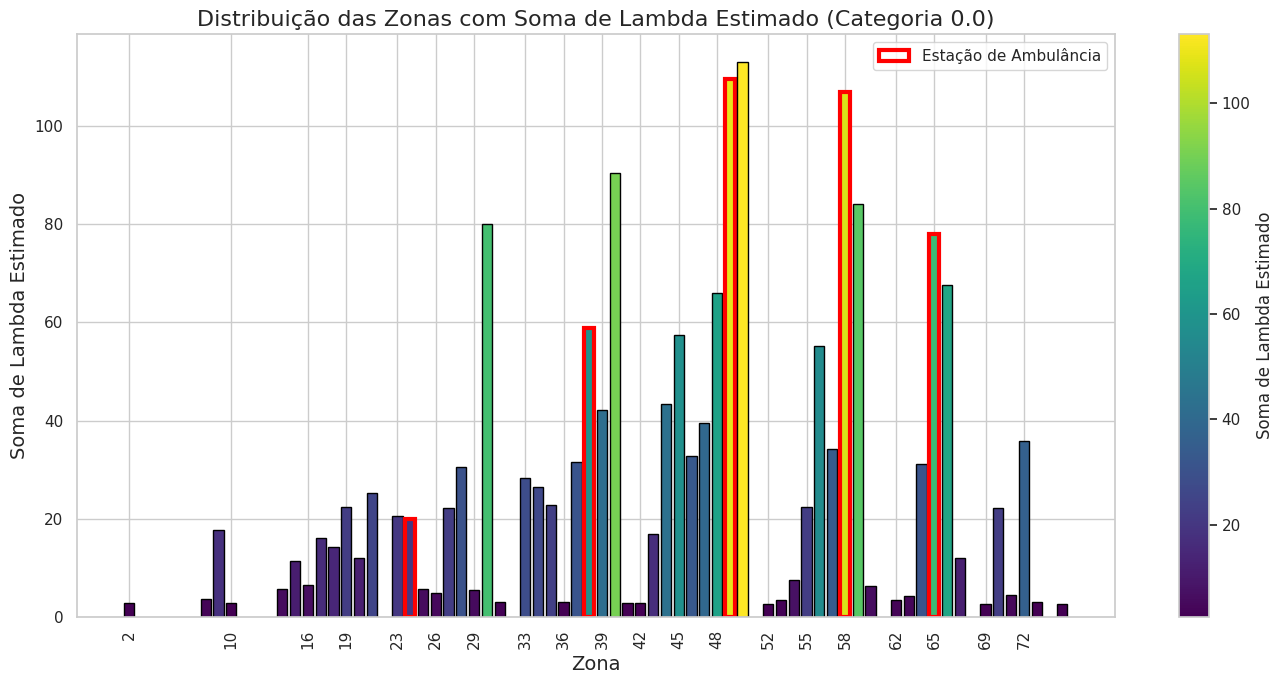

In [ ]:
# Importar as Bibliotecas Necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np

# Configurar o Estilo do Seaborn (Opcional)
sns.set(style="whitegrid")

def definir_distancias(zonas):
    """
    Define a distância entre todas as zonas assumindo que estão dispostas linearmente.
    A distância entre duas zonas é a diferença absoluta entre seus números.
    """
    distancia_matrix = {}
    for zona1 in zonas:
        distancia_matrix[zona1] = {}
        for zona2 in zonas:
            distancia_matrix[zona1][zona2] = abs(zona1 - zona2)
    return distancia_matrix

def calcular_cobertura(zonas, distancia_matrix, estacao, alpha=0.1):
    """
    Calcula a contribuição de cada zona para a cobertura baseada na distância até a estação.

    Parameters:
    - zonas: Lista de zonas.
    - distancia_matrix: Dicionário de distâncias entre zonas.
    - estacao: Zona onde a estação de ambulância está localizada.
    - alpha: Constante de decaimento exponencial.

    Returns:
    - cobertura: Dicionário com a cobertura de cada zona.
    """
    cobertura = {}
    for zona in zonas:
        distancia = distancia_matrix[estacao][zona]
        cobertura[zona] = np.exp(-alpha * distancia)
    return cobertura

def algoritmo_guloso_preparedness(zonas, distancia_matrix, lambda_est, num_estacoes, alpha=0.1):
    """
    Implementa um algoritmo guloso para resolver o problema de cobertura de conjuntos com decaimento de distância.

    Parameters:
    - zonas: Lista de zonas disponíveis.
    - distancia_matrix: Dicionário definindo as distâncias entre zonas.
    - lambda_est: Dicionário com a soma de lambda_est por zona.
    - num_estacoes: Número de estações de ambulância a serem colocadas.
    - alpha: Constante de decaimento exponencial.

    Returns:
    - estacoes_selecionadas: Lista de zonas selecionadas para estações.
    - cobertura_total: Soma ponderada de lambda_est cobertos pelas estações.
    """
    estacoes_selecionadas = []
    cobertura_coberta = {zona: 0 for zona in zonas}
    cobertura_total = 0

    for _ in range(num_estacoes):
        melhor_zona = None
        melhor_ganho = 0
        melhor_cobertura_zonas = {}

        for zona in zonas:
            if zona in estacoes_selecionadas:
                continue
            cobertura = calcular_cobertura(zonas, distancia_matrix, zona, alpha)
            ganho = 0
            cobertura_zonas = {}
            for z in zonas:
                # Cobertura ponderada pela cobertura atual
                ganho += lambda_est[z] * (1 - cobertura_coberta[z]) * cobertura[z]
                cobertura_zonas[z] = cobertura[z]
            if ganho > melhor_ganho:
                melhor_ganho = ganho
                melhor_zona = zona
                melhor_cobertura_zonas = cobertura_zonas

        if melhor_zona is None:
            # Nenhuma zona adicional pode ser coberta
            break

        estacoes_selecionadas.append(melhor_zona)
        # Atualizar a cobertura_coberta
        for z in zonas:
            cobertura_coberta[z] += melhor_cobertura_zonas[z] * (1 - cobertura_coberta[z])
            # Garantir que a cobertura não exceda 1
            cobertura_coberta[z] = min(cobertura_coberta[z], 1)
        # Atualizar a cobertura_total
        cobertura_total = sum([lambda_est[z] * cobertura_coberta[z] for z in zonas])

    return estacoes_selecionadas, cobertura_total

def plot_cobertura(zonas, lambda_est, estacoes_selecionadas):
    """
    Plota o gráfico de barras com as zonas selecionadas destacadas.
    """
    # Configurar o Mapa de Cores e Normalização
    cmap = plt.cm.viridis  # Escolha o colormap desejado
    norm = mpl.colors.Normalize(vmin=min(lambda_est.values()), vmax=max(lambda_est.values()))

    # Criar o Gráfico de Barras
    fig, ax = plt.subplots(figsize=(14, 7))
    zonas_sorted = sorted(zonas)
    lambda_sorted = [lambda_est[z] for z in zonas_sorted]
    colors = cmap(norm(lambda_sorted))
    bars = ax.bar(zonas_sorted, lambda_sorted, color=colors, edgecolor='black')

    # Destacar as zonas com estações de ambulância
    for barra, zona in zip(bars, zonas_sorted):
        if zona in estacoes_selecionadas:
            barra.set_edgecolor('red')
            barra.set_linewidth(3)

    # Personalizar o Gráfico
    ax.set_xlabel('Zona', fontsize=14)
    ax.set_ylabel('Soma de Lambda Estimado', fontsize=14)
    ax.set_title('Distribuição das Zonas com Soma de Lambda Estimado (Categoria 0.0)', fontsize=16)

    # Ajustar os ticks do eixo x
    num_zonas = len(zonas_sorted)
    if num_zonas > 20:
        step = max(1, num_zonas // 20)
        ax.set_xticks(zonas_sorted[::step])
        ax.set_xticklabels(zonas_sorted[::step], rotation=90)
    else:
        ax.set_xticks(zonas_sorted)
        ax.set_xticklabels(zonas_sorted, rotation=90)

    # Adicionar a Barra de Cores (Colorbar)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Soma de Lambda Estimado', fontsize=12)

    # Criar uma legenda para as estações de ambulância
    from matplotlib.patches import Patch
    legenda = [Patch(facecolor='none', edgecolor='red', linewidth=3, label='Estação de Ambulância')]
    ax.legend(handles=legenda, loc='upper right')

    # Melhorar o Layout
    plt.tight_layout()

    # Exibir o Gráfico
    plt.show()

def main():
    # Passo 1: Carregar os Dados
    # ---------------------------------
    # Substitua 'seu_arquivo.csv' pelo caminho do seu arquivo de dados.
        # Filtra as linhas onde categoria='categoria_0.0'
    df=results_df
    df["zona"]=pd.to_numeric(df['zona'], errors='coerce')
    df=df.dropna(subset=['zona'])
    df['zona'] = df['zona'].astype(int)
    filtro = df['categoria'] == 'categoria_0.0'
    df_filtrado = df[filtro].copy()

    # Verificar se o DataFrame filtrado está vazio
    if df_filtrado.empty:
        print("Nenhum dado corresponde aos critérios de filtragem (categoria='categoria_0.0').")
        return

    # Passo 3: Converter a Coluna 'zona' para Inteiro
    # ---------------------------------
    try:
        df_filtrado['zona'] = df_filtrado['zona'].astype(str).str.strip().astype(int)
    except ValueError:
        print("Erro ao converter a coluna 'zona' para inteiro. Verifique os dados na coluna 'zona'.")
        return

    # Passo 4: Agrupar os Dados por 'zona' e Calcular a Soma de 'lambda_est'
    # ---------------------------------
    df_grouped = df_filtrado.groupby('zona', as_index=False)['lambda_est'].sum()

    # Verificar se o agrupamento resultou em dados
    if df_grouped.empty:
        print("Após o agrupamento, não há dados para plotar.")
        return

    # Passo 5: Definir Distâncias entre as Zonas
    # ---------------------------------
    zonas = df_grouped['zona'].tolist()
    distancia_matrix = definir_distancias(zonas)

    # Passo 6: Definir Número de Estações de Ambulância e Alpha
    # ---------------------------------
    num_estacoes = 5  # Ajuste conforme necessário
    alpha = 0.1       # Constante de decaimento exponencial

    # Passo 7: Criar um Dicionário de Lambda Estimado por Zona
    # ---------------------------------
    lambda_est_dict = dict(zip(df_grouped['zona'], df_grouped['lambda_est']))

    # Passo 8: Implementar o Algoritmo de Cobertura com Preparedness
    # ---------------------------------
    estacoes_selecionadas, cobertura_total = algoritmo_guloso_preparedness(
        zonas, distancia_matrix, lambda_est_dict, num_estacoes, alpha
    )

    print(f"Zonas selecionadas para estações de ambulância: {estacoes_selecionadas}")
    print(f"Soma total de Lambda Estimado coberta: {cobertura_total:.4f}")

    # Passo 9: Plotar o Gráfico com Zonas Selecionadas
    # ---------------------------------
    plot_cobertura(zonas, lambda_est_dict, estacoes_selecionadas)

if __name__ == "__main__":
    main()


Zonas selecionadas para estações de ambulância: [49, 58, 30, 39, 66]
Soma total de Lambda Estimado coberta: 761.9366


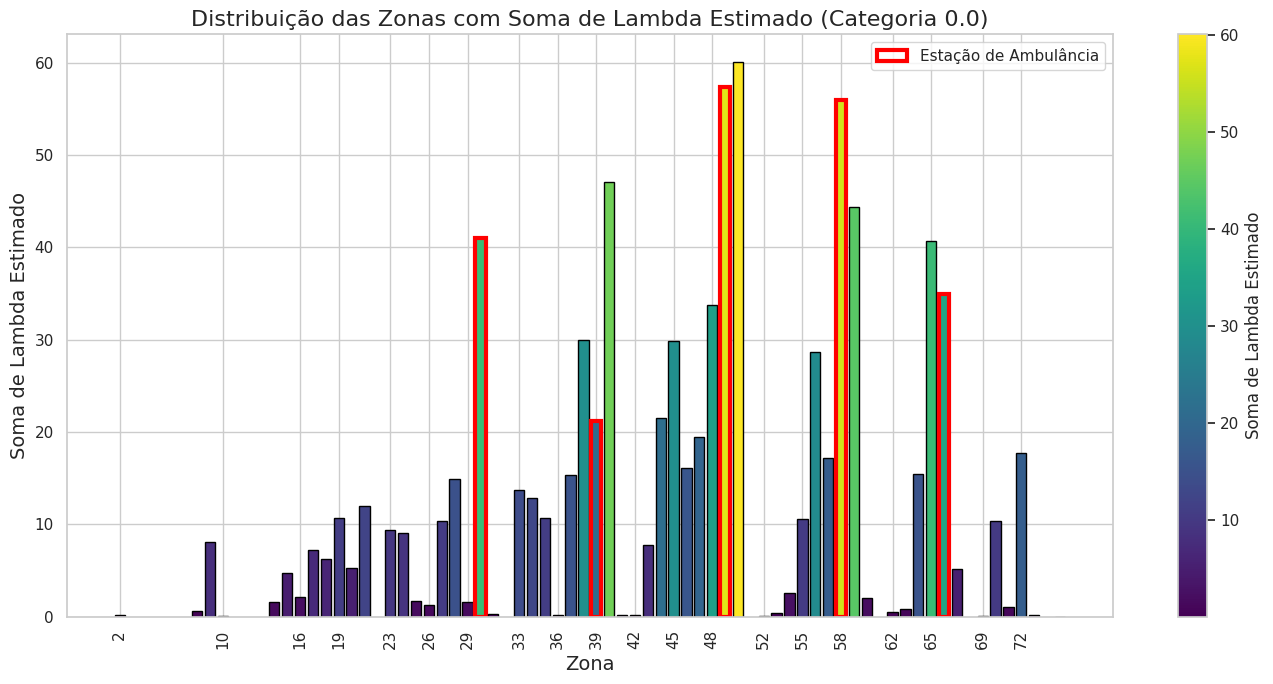

In [ ]:
# Importar as Bibliotecas Necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np

# Configurar o Estilo do Seaborn (Opcional)
sns.set(style="whitegrid")

def definir_distancias(zonas):
    """
    Define a distância entre todas as zonas assumindo que estão dispostas linearmente.
    A distância entre duas zonas é a diferença absoluta entre seus números.
    """
    distancia_matrix = {}
    for zona1 in zonas:
        distancia_matrix[zona1] = {}
        for zona2 in zonas:
            distancia_matrix[zona1][zona2] = abs(zona1 - zona2)
    return distancia_matrix

def calcular_cobertura(zonas, distancia_matrix, estacao, alpha=0.1):
    """
    Calcula a contribuição de cada zona para a cobertura baseada na distância até a estação.

    Parameters:
    - zonas: Lista de zonas.
    - distancia_matrix: Dicionário de distâncias entre zonas.
    - estacao: Zona onde a estação de ambulância está localizada.
    - alpha: Constante de decaimento exponencial.

    Returns:
    - cobertura: Dicionário com a cobertura de cada zona.
    """
    cobertura = {}
    for zona in zonas:
        distancia = distancia_matrix[estacao][zona]
        cobertura[zona] = np.exp(-alpha * distancia)
    return cobertura

def algoritmo_guloso_preparedness(zonas, distancia_matrix, lambda_est, num_estacoes, alpha=0.1):
    """
    Implementa um algoritmo guloso para resolver o problema de cobertura de conjuntos com decaimento de distância.

    Parameters:
    - zonas: Lista de zonas disponíveis.
    - distancia_matrix: Dicionário definindo as distâncias entre zonas.
    - lambda_est: Dicionário com a soma de lambda_est por zona.
    - num_estacoes: Número de estações de ambulância a serem colocadas.
    - alpha: Constante de decaimento exponencial.

    Returns:
    - estacoes_selecionadas: Lista de zonas selecionadas para estações.
    - cobertura_total: Soma ponderada de lambda_est cobertos pelas estações.
    """
    estacoes_selecionadas = []
    cobertura_coberta = {zona: 0 for zona in zonas}
    cobertura_total = 0

    for _ in range(num_estacoes):
        melhor_zona = None
        melhor_ganho = 0
        melhor_cobertura_zonas = {}

        for zona in zonas:
            if zona in estacoes_selecionadas:
                continue
            cobertura = calcular_cobertura(zonas, distancia_matrix, zona, alpha)
            ganho = 0
            cobertura_zonas = {}
            for z in zonas:
                # Cobertura ponderada pela cobertura atual
                ganho += lambda_est[z] * (1 - cobertura_coberta[z]) * cobertura[z]
                cobertura_zonas[z] = cobertura[z]
            if ganho > melhor_ganho:
                melhor_ganho = ganho
                melhor_zona = zona
                melhor_cobertura_zonas = cobertura_zonas

        if melhor_zona is None:
            # Nenhuma zona adicional pode ser coberta
            break

        estacoes_selecionadas.append(melhor_zona)
        # Atualizar a cobertura_coberta
        for z in zonas:
            cobertura_coberta[z] += melhor_cobertura_zonas[z] * (1 - cobertura_coberta[z])
            # Garantir que a cobertura não exceda 1
            cobertura_coberta[z] = min(cobertura_coberta[z], 1)
        # Atualizar a cobertura_total
        cobertura_total = sum([lambda_est[z] * cobertura_coberta[z] for z in zonas])

    return estacoes_selecionadas, cobertura_total

def plot_cobertura(zonas, lambda_est, estacoes_selecionadas):
    """
    Plota o gráfico de barras com as zonas selecionadas destacadas.
    """
    # Configurar o Mapa de Cores e Normalização
    cmap = plt.cm.viridis  # Escolha o colormap desejado
    norm = mpl.colors.Normalize(vmin=min(lambda_est.values()), vmax=max(lambda_est.values()))

    # Criar o Gráfico de Barras
    fig, ax = plt.subplots(figsize=(14, 7))
    zonas_sorted = sorted(zonas)
    lambda_sorted = [lambda_est[z] for z in zonas_sorted]
    colors = cmap(norm(lambda_sorted))
    bars = ax.bar(zonas_sorted, lambda_sorted, color=colors, edgecolor='black')

    # Destacar as zonas com estações de ambulância
    for barra, zona in zip(bars, zonas_sorted):
        if zona in estacoes_selecionadas:
            barra.set_edgecolor('red')
            barra.set_linewidth(3)

    # Personalizar o Gráfico
    ax.set_xlabel('Zona', fontsize=14)
    ax.set_ylabel('Soma de Lambda Estimado', fontsize=14)
    ax.set_title('Distribuição das Zonas com Soma de Lambda Estimado (Categoria 0.0)', fontsize=16)

    # Ajustar os ticks do eixo x
    num_zonas = len(zonas_sorted)
    if num_zonas > 20:
        step = max(1, num_zonas // 20)
        ax.set_xticks(zonas_sorted[::step])
        ax.set_xticklabels(zonas_sorted[::step], rotation=90)
    else:
        ax.set_xticks(zonas_sorted)
        ax.set_xticklabels(zonas_sorted, rotation=90)

    # Adicionar a Barra de Cores (Colorbar)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Soma de Lambda Estimado', fontsize=12)

    # Criar uma legenda para as estações de ambulância
    from matplotlib.patches import Patch
    legenda = [Patch(facecolor='none', edgecolor='red', linewidth=3, label='Estação de Ambulância')]
    ax.legend(handles=legenda, loc='upper right')

    # Melhorar o Layout
    plt.tight_layout()

    # Exibir o Gráfico
    plt.show()

def main():
    # Passo 1: Carregar os Dados
    # ---------------------------------
    # Substitua 'seu_arquivo.csv' pelo caminho do seu arquivo de dados.
        # Filtra as linhas onde categoria='categoria_0.0'
    df=empirical_means_df
    df["zona"]=pd.to_numeric(df['zona'], errors='coerce')
    df=df.dropna(subset=['zona'])
    df['zona'] = df['zona'].astype(int)
    filtro = df['categoria'] == 'categoria_0.0'
    df_filtrado = df[filtro].copy()

    # Verificar se o DataFrame filtrado está vazio
    if df_filtrado.empty:
        print("Nenhum dado corresponde aos critérios de filtragem (categoria='categoria_0.0').")
        return

    # Passo 3: Converter a Coluna 'zona' para Inteiro
    # ---------------------------------
    try:
        df_filtrado['zona'] = df_filtrado['zona'].astype(str).str.strip().astype(int)
    except ValueError:
        print("Erro ao converter a coluna 'zona' para inteiro. Verifique os dados na coluna 'zona'.")
        return

    # Passo 4: Agrupar os Dados por 'zona' e Calcular a Soma de 'lambda_est'
    # ---------------------------------
    df_grouped = df_filtrado.groupby('zona', as_index=False)['empirical_mean'].sum()

    # Verificar se o agrupamento resultou em dados
    if df_grouped.empty:
        print("Após o agrupamento, não há dados para plotar.")
        return

    # Passo 5: Definir Distâncias entre as Zonas
    # ---------------------------------
    zonas = df_grouped['zona'].tolist()
    distancia_matrix = definir_distancias(zonas)

    # Passo 6: Definir Número de Estações de Ambulância e Alpha
    # ---------------------------------
    num_estacoes = 5  # Ajuste conforme necessário
    alpha = 0.1       # Constante de decaimento exponencial

    # Passo 7: Criar um Dicionário de Lambda Estimado por Zona
    # ---------------------------------
    lambda_est_dict = dict(zip(df_grouped['zona'], df_grouped['empirical_mean']))

    # Passo 8: Implementar o Algoritmo de Cobertura com Preparedness
    # ---------------------------------
    estacoes_selecionadas, cobertura_total = algoritmo_guloso_preparedness(
        zonas, distancia_matrix, lambda_est_dict, num_estacoes, alpha
    )

    print(f"Zonas selecionadas para estações de ambulância: {estacoes_selecionadas}")
    print(f"Soma total de Lambda Estimado coberta: {cobertura_total:.4f}")

    # Passo 9: Plotar o Gráfico com Zonas Selecionadas
    # ---------------------------------
    plot_cobertura(zonas, lambda_est_dict, estacoes_selecionadas)

if __name__ == "__main__":
    main()

#[49, 38, 65, 24, 58]

In [ ]:
empirical_means_df

,tempo,dia_semana,categoria,zona,empirical_mean
0,1,1,categoria_0.0,49.0,0.203883
1,1,1,categoria_0.0,58.0,0.126214
2,1,1,categoria_0.0,35.0,0.000000
3,1,1,categoria_0.0,64.0,0.038835
4,1,1,categoria_0.0,21.0,0.038835
...,...,...,...,...,...
60475,48,7,categoria_2.0,2.0,0.000000
60476,48,7,categoria_2.0,41.0,0.000000
60477,48,7,categoria_2.0,10.0,0.000000
60478,48,7,categoria_2.0,75.0,0.000000


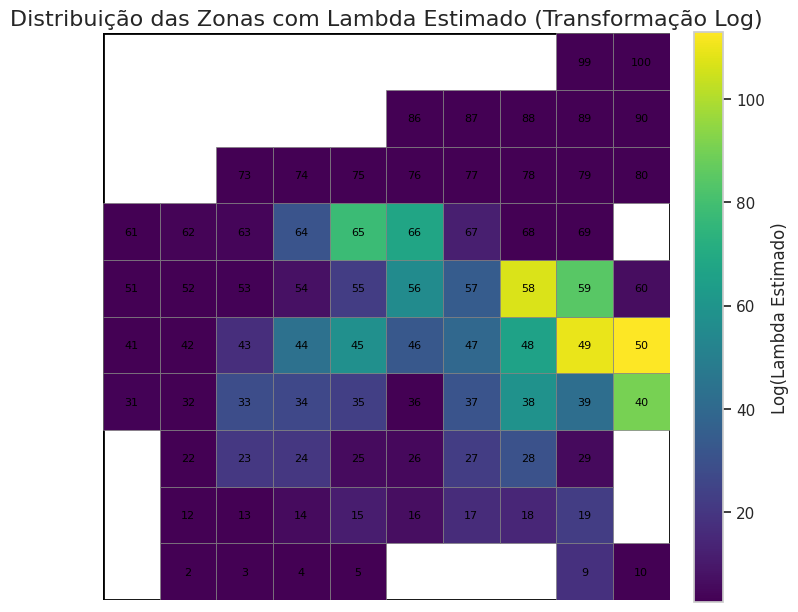

In [ ]:
# Importar as Bibliotecas Necessárias
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import seaborn as sns

# Configurar o Estilo do Seaborn (Opcional)
sns.set(style="whitegrid")


def plot_rectangle_with_colored_squares(width, height, sub_width, sub_height, remover_indices, zone_values, cmap, norm):
    """
    Plota um retângulo subdividido em sub-retângulos com quadrados removidos e cores baseadas em zone_values.
    """
    # Configurações do plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.set_aspect('equal')

    # Adicionando o retângulo principal
    main_rect = patches.Rectangle((0, 0), width, height, edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(main_rect)

    # Adicionando os retângulos subdivididos com cores baseadas em zone_values
    for y in range(0, height, sub_height):
        for x in range(0, width, sub_width):
            col = x // sub_width
            row = y // sub_height
            zone_index = int(row * (width / sub_width) + col + 1)

            if zone_index in remover_indices:
                continue

            lambda_est = zone_values.get(zone_index, 0)
            color = cmap(norm(lambda_est))

            sub_rect = patches.Rectangle((x, y), sub_width, sub_height, edgecolor='gray', facecolor=color, linewidth=0.5)
            ax.add_patch(sub_rect)

            ax.text(x + sub_width / 2, y + sub_height / 2, str(zone_index), color='black',
                    ha='center', va='center', fontsize=8)

    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Log(Lambda Estimado)', fontsize=12)

    ax.set_title("Distribuição das Zonas com Lambda Estimado (Transformação Log)", fontsize=16)
    ax.axis('off')
    plt.show()


def main():

    filtro = df['categoria'] == 'categoria_0.0'
    df_filtrado = df[filtro].copy()  # Usar .copy() para evitar o SettingWithCopyWarning

    # Verificar se o DataFrame filtrado está vazio
    if df_filtrado.empty:
        print("Nenhum dado corresponde aos critérios de filtragem (categoria='categoria_0.0').")
        return

    # Passo 3: Converter a Coluna 'zona' para Inteiro
    # ---------------------------------


    # Passo 4: Agrupar os Dados por 'zona' e Calcular a Soma de 'lambda_est'
    # ---------------------------------
    df_grouped = df_filtrado.groupby('zona', as_index=False)['lambda_est'].sum()

    # Verificar se o agrupamento resultou em dados
    if df_grouped.empty:
        print("Após o agrupamento, não há dados para plotar.")
        return

    # Passo 5: Preparar os Dados para o Plot
    # ---------------------------------
    # Criar um dicionário mapeando zona para soma de lambda_est
    zone_values = pd.Series(df_grouped.lambda_est.values, index=df_grouped.zona).to_dict()

    # Passo 6: Definir os Índices dos Quadrados a Serem Removidos
    # ---------------------------------
    remover_indices = [1, 11, 20, 30, 21, 70, 71, 72, 81] + list(range(91, 99)) + list(range(82, 86)) + list(range(6, 9))

    # Passo 7: Configurar o Mapa de Cores e Normalização
    # ---------------------------------
    cmap = plt.cm.viridis  # Escolha o colormap desejado
    norm = mpl.colors.Normalize(vmin=df_grouped['lambda_est'].min(), vmax=df_grouped['lambda_est'].max())

    # Passo 8: Plotar o Retângulo com Quadrados Coloridos
    # ---------------------------------
    plot_rectangle_with_colored_squares(
        width=100,
        height=100,
        sub_width=10,
        sub_height=10,
        remover_indices=remover_indices,
        zone_values=zone_values,
        cmap=cmap,
        norm=norm
    )

if __name__ == "__main__":
    main()


In [ ]:
df=results_df

Remover índices (0-75): [1, 11, 20, 30, 21, 70, 71, 72, 6, 7, 8]


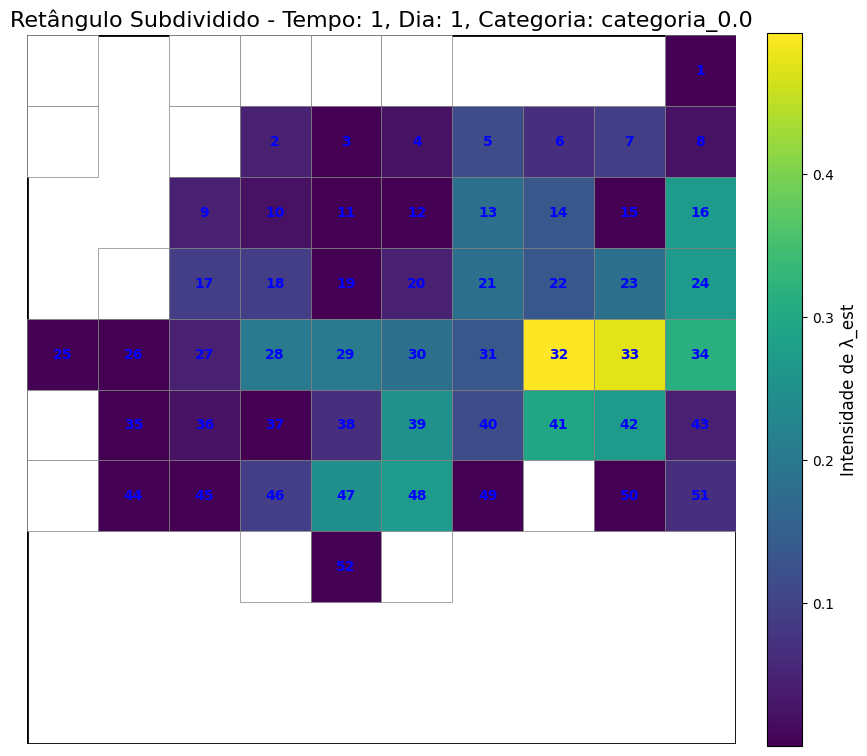

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_rectangle_with_lambda_new(df, width=100, height=100, sub_width=10, sub_height=10, remover_indices=[],
                                   tempo_fixo=1, dia_semana_fixo=1, categoria_fixa='categoria_0.0'):
    """
    Plota um retângulo subdividido em sub-retângulos coloridos com base em lambda_est,
    removendo quadrados especificados e renumerando os restantes.

    :param df: DataFrame contendo os dados.
    :param width: Largura do retângulo principal (default 100).
    :param height: Altura do retângulo principal (default 100).
    :param sub_width: Largura dos sub-retângulos (default 10).
    :param sub_height: Altura dos sub-retângulos (default 10).
    :param remover_indices: Lista de índices dos sub-retângulos a serem removidos (0-75).
    :param tempo_fixo: Valor fixo para a coluna 'tempo' (default 1).
    :param dia_semana_fixo: Valor fixo para a coluna 'dia_semana' (default 1).
    :param categoria_fixa: Valor fixo para a coluna 'categoria' (default 'categoria_0.0').
    """
    # Filtrar o DataFrame com os valores fixos
    df_filtrado = df[
        (df['tempo'] == tempo_fixo) &
        (df['dia_semana'] == dia_semana_fixo) &
        (df['categoria'] == categoria_fixa)
    ].copy()

    # Ajustar 'zona' de 1-76 para 0-75 e converter para inteiro
    df_filtrado['zona'] = pd.to_numeric(df_filtrado['zona'], errors='coerce')
    df_filtrado['zona'] = (df_filtrado['zona'] - 1).astype(int)

    # Remover as zonas que estão em remover_indices
    zonas_para_remover = [idx for idx in remover_indices if 0 <= idx <=75]
    df_filtrado = df_filtrado[~df_filtrado['zona'].isin(zonas_para_remover)]

    # Criar um dicionário mapeando zona para lambda_est
    zona_lambda = df_filtrado.set_index('zona')['lambda_est'].to_dict()

    # Renumerar as zonas restantes
    sorted_zonas = sorted(zona_lambda.keys())
    zona_new_number = {zona: i+1 for i, zona in enumerate(sorted_zonas)}

    # Configurações do plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.set_aspect('equal')

    # Adicionando o retângulo principal
    main_rect = patches.Rectangle((0, 0), width, height, edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(main_rect)

    # Preparar para coloração
    if zona_lambda:
        lambda_values = list(zona_lambda.values())
        norm = Normalize(vmin=min(lambda_values), vmax=max(lambda_values))
        cmap = plt.get_cmap('viridis')  # Escolha do colormap
    else:
        # Caso não haja zonas para plotar
        norm = Normalize(vmin=0, vmax=1)
        cmap = plt.get_cmap('viridis')

    # Adicionando os retângulos subdivididos com cores baseadas em lambda_est
    for y in range(height - sub_height, -1, -sub_height):  # Iteração de cima para baixo
        for x in range(0, width, sub_width):  # Iteração da esquerda para a direita
            # Calcular o zona_index baseado na posição
            col = x // sub_width
            row = (height - y - sub_height) // sub_height
            zona_index = row * (width // sub_width) + col  # 0-based index

            if zona_index >= 76:
                # Quadrados além das zonas (76-99) são removidos
                continue

            if zona_index in remover_indices:
                # Quadrado removido, não plotara
                continue

            if zona_index in zona_lambda:
                # Obter o valor de lambda_est
                lambda_val = zona_lambda[zona_index]
                color = cmap(norm(lambda_val))
                # Obter o novo número
                new_number = zona_new_number[zona_index]
            else:
                # Se a zona não tiver dados, colorir de branco e sem número
                color = 'white'
                new_number = None

            # Plotar o quadrado com a cor correspondente
            sub_rect = patches.Rectangle((x, y), sub_width, sub_height, edgecolor='gray',
                                         facecolor=color, linewidth=0.5)
            ax.add_patch(sub_rect)

            # Adicionar a nova numeração no centro do quadrado, se existir
            if new_number is not None:
                ax.text(x + sub_width / 2, y + sub_height / 2, str(new_number), color='blue',
                        ha='center', va='center', fontsize=10, fontweight='bold')

    # Remoção de eixos e título
    ax.set_title(f"Retângulo Subdividido - Tempo: {tempo_fixo}, Dia: {dia_semana_fixo}, Categoria: {categoria_fixa}", fontsize=16)
    ax.axis('off')

    # Adicionar barra de cores
    if zona_lambda:
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Intensidade de λ_est', fontsize=12)

    # Mostrar o gráfico
    plt.show()

if __name__ == "__main__":

    # Definir os índices a serem removidos (0-based)
    remover_indices = [1, 11, 20, 30, 21, 70, 71, 72, 81] + list(range(91, 99)) + list(range(82, 86)) + list(range(6, 9))
    # Ajustar para incluir apenas índices de 0 a 75
    remover_indices = [idx for idx in remover_indices if 0 <= idx <=75]

    # Para visualização, imprimir os índices que serão removidos
    print("Remover índices (0-75):", remover_indices)

    # Chamar a função com os parâmetros fixos
    plot_rectangle_with_lambda_new(
        df=df,
        width=100,
        height=100,
        sub_width=10,
        sub_height=10,
        remover_indices=remover_indices,
        tempo_fixo=1,
        dia_semana_fixo=1,
        categoria_fixa='categoria_0.0'
    )


Remover índices (0-75): [1, 11, 20, 30, 21, 70, 71, 72, 6, 7, 8]


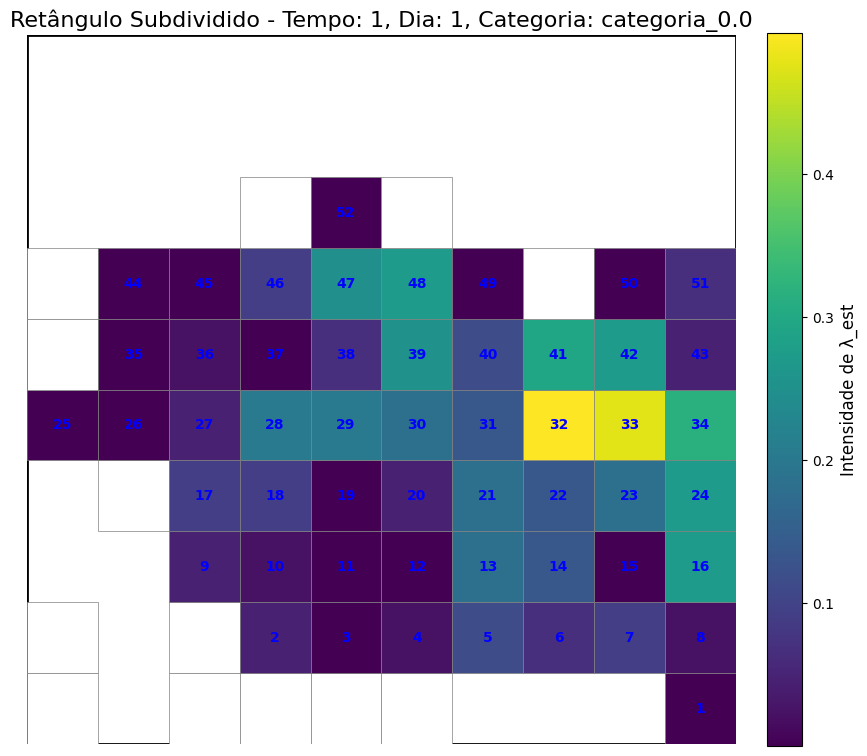

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_rectangle_with_lambda_corrected(df, width=100, height=100, sub_width=10, sub_height=10, remover_indices=[],
                                       tempo_fixo=1, dia_semana_fixo=1, categoria_fixa='categoria_0.0'):
    """
    Plota um retângulo subdividido em sub-retângulos coloridos com base em lambda_est,
    removendo quadrados especificados e renumerando os restantes.

    :param df: DataFrame contendo os dados.
    :param width: Largura do retângulo principal (default 100).
    :param height: Altura do retângulo principal (default 100).
    :param sub_width: Largura dos sub-retângulos (default 10).
    :param sub_height: Altura dos sub-retângulos (default 10).
    :param remover_indices: Lista de índices dos sub-retângulos a serem removidos (0-75).
    :param tempo_fixo: Valor fixo para a coluna 'tempo' (default 1).
    :param dia_semana_fixo: Valor fixo para a coluna 'dia_semana' (default 1).
    :param categoria_fixa: Valor fixo para a coluna 'categoria' (default 'categoria_0.0').
    """
    # Filtrar o DataFrame com os valores fixos
    df_filtrado = df[
        (df['tempo'] == tempo_fixo) &
        (df['dia_semana'] == dia_semana_fixo) &
        (df['categoria'] == categoria_fixa)
    ].copy()
    df_filtrado['zona'] = pd.to_numeric(df_filtrado['zona'], errors='coerce')
    # Ajustar 'zona' de 1-76 para 0-75 e converter para inteiro
    df_filtrado['zona'] = (df_filtrado['zona'] - 1).astype(int)

    # Remover as zonas que estão em remover_indices (apenas 0-75)
    zonas_para_remover = [idx for idx in remover_indices if 0 <= idx <=75]
    df_filtrado = df_filtrado[~df_filtrado['zona'].isin(zonas_para_remover)]

    # Criar um dicionário mapeando zona para lambda_est
    zona_lambda = df_filtrado.set_index('zona')['lambda_est'].to_dict()

    # Renumerar as zonas restantes sequencialmente
    sorted_zonas = sorted(zona_lambda.keys())
    zona_new_number = {zona: i+1 for i, zona in enumerate(sorted_zonas)}

    # Configurações do plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.set_aspect('equal')

    # Adicionando o retângulo principal
    main_rect = patches.Rectangle((0, 0), width, height, edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(main_rect)

    # Preparar para coloração
    if zona_lambda:
        lambda_values = list(zona_lambda.values())
        norm = Normalize(vmin=min(lambda_values), vmax=max(lambda_values))
        cmap = plt.get_cmap('viridis')  # Escolha do colormap
    else:
        # Caso não haja zonas para plotar
        norm = Normalize(vmin=0, vmax=1)
        cmap = plt.get_cmap('viridis')

    # Número sequencial para os quadrados restantes
    new_count = 1

    # Número de colunas no grid
    num_cols = width // sub_width

    # Adicionando os retângulos subdivididos com cores baseadas em lambda_est
    for y in range(0, height, sub_height):  # Iteração de baixo para cima
        for x in range(0, width, sub_width):  # Iteração da esquerda para a direita
            # Calcular o grid_index baseado na posição
            row = y // sub_height  # 0 no fundo, aumentando para cima
            col = x // sub_width   # 0 à esquerda, aumentando para a direita
            grid_index = row * num_cols + col  # 0-based index

            if grid_index >= 76:
                # Quadrados além das zonas (76-99) são removidos
                continue

            if grid_index in zonas_para_remover:
                # Quadrado removido, não plotar
                continue

            if grid_index in zona_lambda:
                # Obter o valor de lambda_est
                lambda_val = zona_lambda[grid_index]
                color = cmap(norm(lambda_val))
                # Obter o novo número
                new_number = zona_new_number[grid_index]
            else:
                # Se a zona não tiver dados, colorir de branco e sem número
                color = 'white'
                new_number = None

            # Plotar o quadrado com a cor correspondente
            sub_rect = patches.Rectangle((x, y), sub_width, sub_height, edgecolor='gray',
                                         facecolor=color, linewidth=0.5)
            ax.add_patch(sub_rect)

            # Adicionar a nova numeração no centro do quadrado, se existir
            if new_number is not None:
                ax.text(x + sub_width / 2, y + sub_height / 2, str(new_number), color='blue',
                        ha='center', va='center', fontsize=10, fontweight='bold')

    # Remoção de eixos e título
    ax.set_title(f"Retângulo Subdividido - Tempo: {tempo_fixo}, Dia: {dia_semana_fixo}, Categoria: {categoria_fixa}", fontsize=16)
    ax.axis('off')

    # Adicionar barra de cores
    if zona_lambda:
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Intensidade de λ_est', fontsize=12)

    # Mostrar o gráfico
    plt.show()

if __name__ == "__main__":
    # Exemplo de DataFrame

    # Definir os índices a serem removidos (0-based)
    remover_indices = [1, 11, 20, 30, 21, 70, 71, 72, 81] + list(range(91, 99)) + list(range(82, 86)) + list(range(6, 9))
    # Ajustar para incluir apenas índices de 0 a 75
    remover_indices = [idx for idx in remover_indices if 0 <= idx <=75]

    # Para visualização, imprimir os índices que serão removidos
    print("Remover índices (0-75):", remover_indices)

    # Chamar a função com os parâmetros fixos
    plot_rectangle_with_lambda_corrected(
        df=df,
        width=100,
        height=100,
        sub_width=10,
        sub_height=10,
        remover_indices=remover_indices,
        tempo_fixo=1,
        dia_semana_fixo=1,
        categoria_fixa='categoria_0.0'
    )


In [ ]:
 list(range(92, 98))


#The rest of your code will work fine with this modification

[92, 93, 94, 95, 96, 97]

In [ ]:
results_df.head(9)

,tempo,dia_semana,categoria,zona,lambda_est,log_likelihood
0,1,1,categoria_0.0,49.0,4.762225e-01,-2212.106299
1,1,1,categoria_0.0,58.0,2.948046e-01,-2212.106299
2,1,1,categoria_0.0,35.0,4.740410e-07,-2212.106299
3,1,1,categoria_0.0,64.0,9.070943e-02,-2212.106299
4,1,1,categoria_0.0,21.0,9.070943e-02,-2212.106299
5,1,1,categoria_0.0,38.0,1.360639e-01,-2212.106299
6,1,1,categoria_0.0,39.0,1.814184e-01,-2212.106299
7,1,1,categoria_0.0,48.0,4.988998e-01,-2212.106299
8,1,1,categoria_0.0,65.0,2.494501e-01,-2212.106299


In [ ]:
empirical_means_df.head(9)

,tempo,dia_semana,categoria,zona,empirical_mean
0,1,1,categoria_0.0,49.0,0.203883
1,1,1,categoria_0.0,58.0,0.126214
2,1,1,categoria_0.0,35.0,0.000000
3,1,1,categoria_0.0,64.0,0.038835
4,1,1,categoria_0.0,21.0,0.038835
5,1,1,categoria_0.0,38.0,0.058252
6,1,1,categoria_0.0,39.0,0.077670
7,1,1,categoria_0.0,48.0,0.213592
8,1,1,categoria_0.0,65.0,0.106796


In [ ]:
import numpy as np
import pandas as pd

# Suponha que results_df já esteja carregado com os resultados do algoritmo EM
# Exemplo de criação do DataFrame results_df
# results_df = pd.read_csv('results_df.csv')  # Carregue os resultados reais aqui

# Função para calcular a soma dos parâmetros estimados e comparar com os dados reais
def analyze_combination(df_results, tempo, dia_semana, categoria):
    # Filtrar os resultados para a combinação de tempo, dia_semana e categoria
    filtered_results = df_results[
        (df_results['tempo'] == tempo) &
        (df_results['dia_semana'] == dia_semana) &
        (df_results['categoria'] == categoria)
    ]

    if filtered_results.empty:
        print(f"No results found for time={tempo}, day_of_week={dia_semana}, category={categoria}")
        return

    # Soma dos lambdas estimados
    lambda_sum_estimated = filtered_results['lambda_est'].apply(np.sum).sum()

    # Obter os dados reais (precisamos calcular isso a partir do DataFrame original)
    # Para isso, deve-se garantir que temos um DataFrame original com as colunas necessárias
    # Exemplo de criação do DataFrame df (dados reais)
    # df = pd.read_csv('your_data.csv')  # Carregue os dados reais aqui

    # Filtrar os dados reais para a mesma combinação
    filtered_data = df[
        (df['tempo'] == tempo) &
        (df['dia_semana'] == dia_semana)
    ]

    # Somar as colunas de dados observados e não observados
    zona_77_sum = filtered_data[[col for col in filtered_data.columns if 'zona_77' in col]].sum().sum()
    other_zones_sum = filtered_data[[col for col in filtered_data.columns if 'zona_77' not in col]].sum().sum()

    # Imprimir os resultados
    print(f"Combination: Time={tempo}, Day of Week={dia_semana}, Category={categoria}")
    print(f"Estimated sum of lambdas: {lambda_sum_estimated*123}")
    print(f"Real sum of observed data (zona_77): {zona_77_sum+other_zones_sum}")


# Exemplo de uso
analyze_combination(results_df, tempo=3, dia_semana=1, categoria='categoria_2.0')


Combination: Time=3, Day of Week=1, Category=categoria_2.0
Estimated sum of lambdas: 653.2135922330096
Real sum of observed data (zona_77): 1251


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import poisson

# Função para aplicar o algoritmo EM em um conjunto específico (S e Y's)
def em_algorithm_single(S, Y, p_true, max_iter=100, tol=1e-6):
    n = Y.shape[0]  # Número de categorias
    lambda_est = np.ones(n)  # Inicializar lambda com 1
    lambda_history = [lambda_est.copy()]  # Lista para armazenar histórico das estimativas
    log_likelihood_history = []  # Lista para armazenar histórico da verossimilhança

    def log_likelihood(lambda_est):
        # Calcula a log-verossimilhança
        X_conditional_mean = np.array([
            S * (p_true[i] * lambda_est[i]) / np.sum(p_true * lambda_est)
            for i in range(n)
        ])
        return np.sum([
            np.sum(X_conditional_mean[i] * np.log(p_true[i] * lambda_est[i])
                   - p_true[i] * lambda_est[i])
            + np.sum(Y[i] * np.log((1 - p_true[i]) * lambda_est[i])
                   - (1 - p_true[i]) * lambda_est[i])
            for i in range(n)
        ])

    for _ in range(max_iter):
        # Etapa E: Calcular a esperança condicional
        X_conditional_mean = np.array([
            S * (p_true[i] * lambda_est[i]) / np.sum(p_true * lambda_est)
            for i in range(n)
        ])

        # Etapa M: Atualizar lambda
        lambda_new = np.array([
            np.mean(X_conditional_mean[i] + Y[i])
            for i in range(n)
        ])

        # Adicionar a nova estimativa ao histórico
        lambda_history.append(lambda_new.copy())

        # Calcular e armazenar a verossimilhança
        log_likelihood_value = log_likelihood(lambda_new)
        log_likelihood_history.append(log_likelihood_value)

        # Verificar convergência
        if np.all(np.abs(lambda_new - lambda_est) < tol):
            break

        lambda_est = lambda_new

    return lambda_est, lambda_history, log_likelihood_history

# Função para prever as somas de observações
def predict_sum(S_test, Y_test, lambda_est, p_true):
    predicted_X = np.array([
        S_test * (p_true[i] * lambda_est[i]) / np.sum(p_true * lambda_est)
        for i in range(len(lambda_est))
    ])
    return predicted_X + Y_test

# Preparação dos dados
# Exemplo de carregamento de dados
# df = pd.read_csv('your_data.csv')  # Carregue os dados reais aqui

# Separar colunas
S_columns = [col for col in df.columns if 'zona_77' in col]
Y_columns = [col for col in df.columns if 'zona_77' not in col and 'categoria' in col]

# Preparação para treinamento e teste
results = []
empirical_means = []

# Iterando sobre combinações únicas de 'tempo' e 'dia_semana'
for (tempo, dia_semana), group in df.groupby(['tempo', 'dia_semana']):

    # Separar os dados em treinamento e teste
    train_group, test_group = train_test_split(group, test_size=0.2, random_state=42)

    # Preparar conjuntos de treinamento
    S_train = train_group[S_columns].sum(axis=1).values
    Y_train = train_group[[col for col in Y_columns if 'categoria' in col]].values.T
    p_true = np.full(Y_train.shape[0], 0.3)  # p_true fixo em 0.3

    # Aplicar o algoritmo EM no conjunto de treinamento
    lambda_est, _, _ = em_algorithm_single(S_train, Y_train, p_true)

    # Preparar conjuntos de teste
    S_test = test_group[S_columns].sum(axis=1).values
    Y_test = test_group[[col for col in Y_columns if 'categoria' in col]].values.T

    # Prever as somas de observações
    predicted_sums = []
    for i in range(len(S_test)):
        predicted_sum = predict_sum(S_test[i], Y_test[:, i], lambda_est, p_true)
        predicted_sums.append(predicted_sum)

    # Armazenar resultados de previsão
    for i in range(len(predicted_sums)):
        results.append({
            'tempo': tempo,
            'dia_semana': dia_semana,
            'categoria': 'categoria_0.0',  # Ajustar conforme necessário
            'predicted_sum': predicted_sums[i].sum(),
            'actual_sum': (S_test[i] + Y_test[:, i]).sum()
        })

    # Armazenar as médias empíricas
    for cat in ['categoria_0.0', 'categoria_1.0', 'categoria_2.0']:
        empirical_means.append({
            'tempo': tempo,
            'dia_semana': dia_semana,
            'categoria': cat,
            'zona': [col.split('_')[1] for col in Y_columns if cat in col],
            'empirical_mean': group[[col for col in Y_columns if cat in col]].mean().mean()
        })

# Converter os resultados em DataFrames para análise
results_df = pd.DataFrame(results)
empirical_means_df = pd.DataFrame(empirical_means)

# Exibir as primeiras linhas do DataFrame de resultados e médias empíricas
print(results_df.head())
print(empirical_means_df.head())


   tempo  dia_semana      categoria  predicted_sum  actual_sum
0      1           1  categoria_0.0            8.0         724
1      1           1  categoria_0.0           16.0        1806
2      1           1  categoria_0.0           12.0         370
3      1           1  categoria_0.0           11.0        1264
4      1           1  categoria_0.0           16.0        1269
   tempo  dia_semana      categoria  \
0      1           1  categoria_0.0   
1      1           1  categoria_1.0   
2      1           1  categoria_2.0   
3      1           2  categoria_0.0   
4      1           2  categoria_1.0   

                                                zona  empirical_mean  
0  [49.0, 58.0, 35.0, 64.0, 21.0, 38.0, 39.0, 48....        0.044337  
1  [49.0, 58.0, 35.0, 64.0, 21.0, 38.0, 39.0, 48....        0.016019  
2  [49.0, 58.0, 35.0, 64.0, 21.0, 38.0, 39.0, 48....        0.035275  
3  [49.0, 58.0, 35.0, 64.0, 21.0, 38.0, 39.0, 48....        0.038026  
4  [49.0, 58.0, 35.0, 64.0, 21.0

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import poisson
import itertools

# Suponha que df é o seu DataFrame que contém as colunas mencionadas
# df = pd.read_csv('your_data.csv')  # Carregue os dados reais aqui

# Função para aplicar o algoritmo EM em um conjunto específico (S e Y's)
def em_algorithm_single(S, Y, p_true, max_iter=100, tol=1e-6):
    n = Y.shape[0]  # Número de categorias
    lambda_est = np.ones(n)  # Inicializar lambda com 1
    lambda_history = [lambda_est.copy()]  # Lista para armazenar histórico das estimativas
    log_likelihood_history = []  # Lista para armazenar histórico da verossimilhança

    def log_likelihood(lambda_est):
        # Calcula a log-verossimilhança
        X_conditional_mean = np.array([
            S * (p_true[i] * lambda_est[i]) / np.sum(p_true * lambda_est)
            for i in range(n)
        ])
        return np.sum([
            np.sum(X_conditional_mean[i] * np.log(p_true[i] * lambda_est[i])
                   - p_true[i] * lambda_est[i])
            + np.sum(Y[i] * np.log((1 - p_true[i]) * lambda_est[i])
                   - (1 - p_true[i]) * lambda_est[i])
            for i in range(n)
        ])

    for _ in range(max_iter):
        # Etapa E: Calcular a esperança condicional
        X_conditional_mean = np.array([
            S * (p_true[i] * lambda_est[i]) / np.sum(p_true * lambda_est)
            for i in range(n)
        ])

        # Etapa M: Atualizar lambda
        lambda_new = np.array([
            np.mean(X_conditional_mean[i] + Y[i])
            for i in range(n)
        ])

        # Adicionar a nova estimativa ao histórico
        lambda_history.append(lambda_new.copy())

        # Calcular e armazenar a verossimilhança
        log_likelihood_value = log_likelihood(lambda_new)
        log_likelihood_history.append(log_likelihood_value)

        # Verificar convergência
        if np.all(np.abs(lambda_new - lambda_est) < tol):
            break

        lambda_est = lambda_new

    return lambda_est, lambda_history, log_likelihood_history

# Preparação para o loop
results = []
empirical_means = []
sums_lambda_comparison = []

# Iterando sobre combinações únicas de 'tempo' e 'dia_semana'
for (tempo, dia_semana), group in df.groupby(['tempo', 'dia_semana']):

    # Separar as colunas que correspondem a cada conjunto S e Y
    S = group[[col for col in group.columns if 'zona_77' in col]].sum(axis=1).values  # Conjunto S para zona_77
    Y_columns = [col for col in group.columns if 'zona_77' not in col and 'categoria' in col]  # Outras zonas

    for cat in ['categoria_0.0', 'categoria_1.0', 'categoria_2.0']:
        Y = group[[col for col in Y_columns if cat in col]].values.T  # Pegando os Y_i para cada categoria

        # Definindo p_true como 0.3 para todas as categorias
        p_true = np.full(Y.shape[0], 0.3)  # Definindo p_true como 0.3 para todos os Y_i

        # Aplicar o algoritmo EM
        lambda_est, lambda_history, log_likelihood_history = em_algorithm_single(S, Y, p_true)

        # Armazenar os resultados das estimativas
        for idx, zona in enumerate([col.split('_')[1] for col in Y_columns if cat in col]):
            results.append({
                'tempo': tempo,
                'dia_semana': dia_semana,
                'categoria': cat,
                'zona': zona,
                'lambda_est': lambda_est[idx],
                'log_likelihood': log_likelihood_history[-1]
            })

        # Armazenar as médias empíricas
        for idx, zona in enumerate([col.split('_')[1] for col in Y_columns if cat in col]):
            empirical_means.append({
                'tempo': tempo,
                'dia_semana': dia_semana,
                'categoria': cat,
                'zona': zona,
                'empirical_mean': Y[idx].mean()
            })

        # Comparar a soma dos valores estimados de lambda com o valor de S
        sum_lambda_est = np.sum(lambda_est)
        sum_S = np.sum(S)

        sums_lambda_comparison.append({
            'tempo': tempo,
            'dia_semana': dia_semana,
            'categoria': cat,
            'sum_lambda_est': sum_lambda_est,
            'sum_S': sum_S,
            'difference': sum_lambda_est - sum_S
        })

# Converter os resultados em DataFrames para análise
results_df = pd.DataFrame(results)
empirical_means_df = pd.DataFrame(empirical_means)
sums_lambda_comparison_df = pd.DataFrame(sums_lambda_comparison)

# Exibir as primeiras linhas dos DataFrames de resultados, médias empíricas e comparação
print("Results DataFrame:")
print(results_df.head())

print("\nEmpirical Means DataFrame:")
print(empirical_means_df.head())

print("\nSums Lambda Comparison DataFrame:")
print(sums_lambda_comparison_df.head())


Results DataFrame:
   tempo  dia_semana      categoria  zona    lambda_est  log_likelihood
0      1           1  categoria_0.0  49.0  4.762225e-01    -2212.106299
1      1           1  categoria_0.0  58.0  2.948046e-01    -2212.106299
2      1           1  categoria_0.0  35.0  4.740410e-07    -2212.106299
3      1           1  categoria_0.0  64.0  9.070943e-02    -2212.106299
4      1           1  categoria_0.0  21.0  9.070943e-02    -2212.106299

Empirical Means DataFrame:
   tempo  dia_semana      categoria  zona  empirical_mean
0      1           1  categoria_0.0  49.0        0.203883
1      1           1  categoria_0.0  58.0        0.126214
2      1           1  categoria_0.0  35.0        0.000000
3      1           1  categoria_0.0  64.0        0.038835
4      1           1  categoria_0.0  21.0        0.038835

Sums Lambda Comparison DataFrame:
   tempo  dia_semana      categoria  sum_lambda_est  sum_S  difference
0      1           1  categoria_0.0        6.213592    366 -359.786

In [ ]:
import numpy as np
import pandas as pd

# Suponha que results_df já esteja carregado com os resultados do algoritmo EM
# Exemplo de criação do DataFrame results_df
# results_df = pd.read_csv('results_df.csv')  # Carregue os resultados reais aqui

# Função para calcular a soma dos parâmetros estimados e comparar com os dados reais
def analyze_combination(df_results, tempo, dia_semana, categoria):
    # Filtrar os resultados para a combinação de tempo, dia_semana e categoria
    filtered_results = df_results[
        (df_results['tempo'] == tempo) &
        (df_results['dia_semana'] == dia_semana) &
        (df_results['categoria'] == categoria)
    ]

    if filtered_results.empty:
        print(f"No results found for time={tempo}, day_of_week={dia_semana}, category={categoria}")
        return

    # Soma dos lambdas estimados
    lambda_sum_estimated = filtered_results['lambda_est'].apply(np.sum).sum()

    # Obter os dados reais (precisamos calcular isso a partir do DataFrame original)
    # Para isso, deve-se garantir que temos um DataFrame original com as colunas necessárias
    # Exemplo de criação do DataFrame df (dados reais)
    # df = pd.read_csv('your_data.csv')  # Carregue os dados reais aqui

    # Filtrar os dados reais para a mesma combinação
    filtered_data = df[
        (df['tempo'] == tempo) &
        (df['dia_semana'] == dia_semana)
    ]

    # Somar as colunas de dados observados e não observados
    zona_77_sum = filtered_data[[col for col in filtered_data.columns if 'zona_77' in col]].sum().sum()
    other_zones_sum = filtered_data[[col for col in filtered_data.columns if 'zona_77' not in col]].sum().sum()

    # Imprimir os resultados
    print(f"Combination: Time={tempo}, Day of Week={dia_semana}, Category={categoria}")
    print(f"Estimated sum of lambdas: {lambda_sum_estimated}")
    print(f"Real sum of observed data (zona_77): {zona_77_sum}")
    print(f"Real sum of observed data (other zones): {other_zones_sum}")

# Exemplo de uso
analyze_combination(results_df, tempo=1, dia_semana='Monday', categoria='categoria_0.0')


No results found for time=1, day_of_week=Monday, category=categoria_0.0


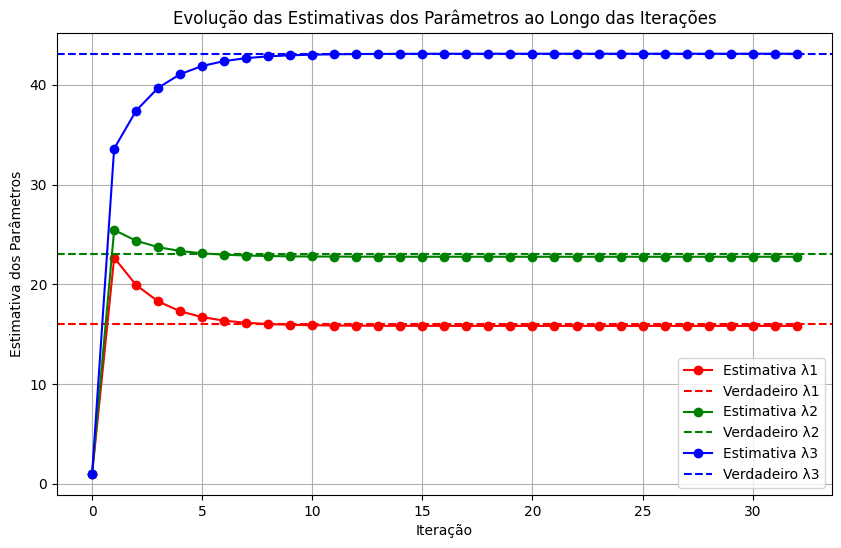

Parâmetros verdadeiros: [16.01 23.04 43.05]
Parâmetros estimados: [15.82095442 22.75821682 43.12082876]


In [ ]:
##### RASCUBNHO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Configurações do modelo


# Parâmetros verdadeiros
lambda_true = np.array([16.01, 23.04, 43.05])  # Taxas de Poisson
p = 0.6  # Probabilidade para X_i (scalar)

# Número de amostras
n_samples = 100

# Função para gerar dados
def generate_data(lambda_true, p, n_samples):
    Y = []
    for i in range(len(lambda_true)):
        Y_i = poisson.rvs((1 - p) * lambda_true[i], size=n_samples)
        Y.append(Y_i)
    Y = np.array(Y)
    S_true = np.sum(lambda_true)
    Z = poisson.rvs(p * S_true, size=n_samples)
    return Y, Z

# Gerar dados simulados
Y, Z = generate_data(lambda_true, p, n_samples)

# Função do algoritmo EM com rastreamento da evolução dos parâmetros
def em_algorithm(Y, Z, max_iter=100, tol=1e-6):
    n = len(Y)  # Número de componentes (i)
    n_samples = Y.shape[1]  # Número de amostras (n)
    lambda_est = np.ones(n)  # Inicializar lambda com 1
    lambda_history = [lambda_est.copy()]  # Lista para armazenar histórico das estimativas

    for _ in range(max_iter):
        S_est = np.sum(lambda_est)  # Somatório das estimativas lambda atuais

        # Etapa E: Calcular a esperança condicional
        E_X = np.array([
            Z * lambda_est[i] / S_est
            for i in range(n)
        ])  # E_X tem shape (n, n_samples)

        # Etapa M: Atualizar lambda
        lambda_new = np.array([
            np.mean(E_X[i] + Y[i])
            for i in range(n)
        ])

        # Adicionar a nova estimativa ao histórico
        lambda_history.append(lambda_new.copy())

        # Verificar convergência
        if np.all(np.abs(lambda_new - lambda_est) < tol):
            break

        lambda_est = lambda_new

    return lambda_est, lambda_history

# Aplicar o algoritmo EM
lambda_estimated, lambda_history = em_algorithm(Y, Z)

# Plotar a evolução das estimativas
plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b']  # Definir cores para cada parâmetro
n_params = len(lambda_true)

for i in range(n_params):
    # Plotar evolução das estimativas
    plt.plot([l[i] for l in lambda_history], label=f'Estimativa λ{i+1}', marker='o', color=colors[i])
    # Plotar linha horizontal do valor verdadeiro
    plt.axhline(y=lambda_true[i], color=colors[i], linestyle='--', label=f'Verdadeiro λ{i+1}')

plt.xlabel('Iteração')
plt.ylabel('Estimativa dos Parâmetros')
plt.title('Evolução das Estimativas dos Parâmetros ao Longo das Iterações')
plt.legend()
plt.grid(True)
plt.show()

print("Parâmetros verdadeiros:", lambda_true)
print("Parâmetros estimados:", lambda_estimated)



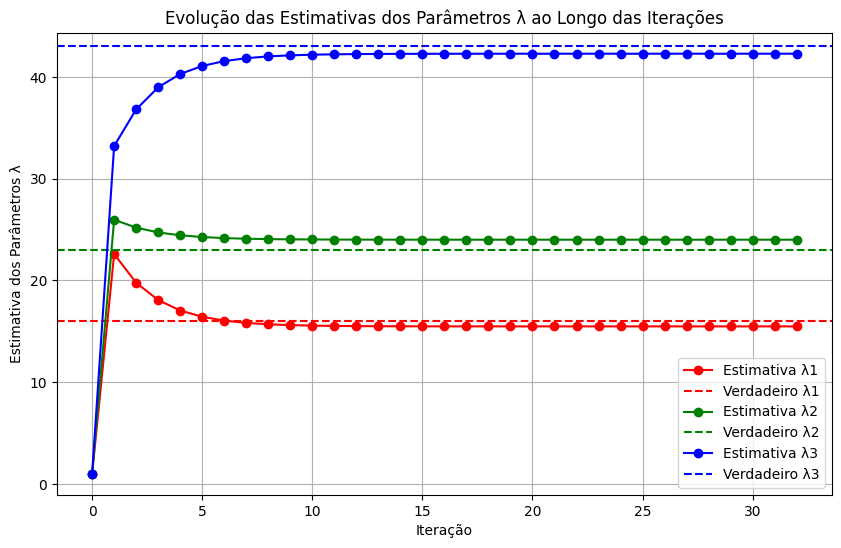

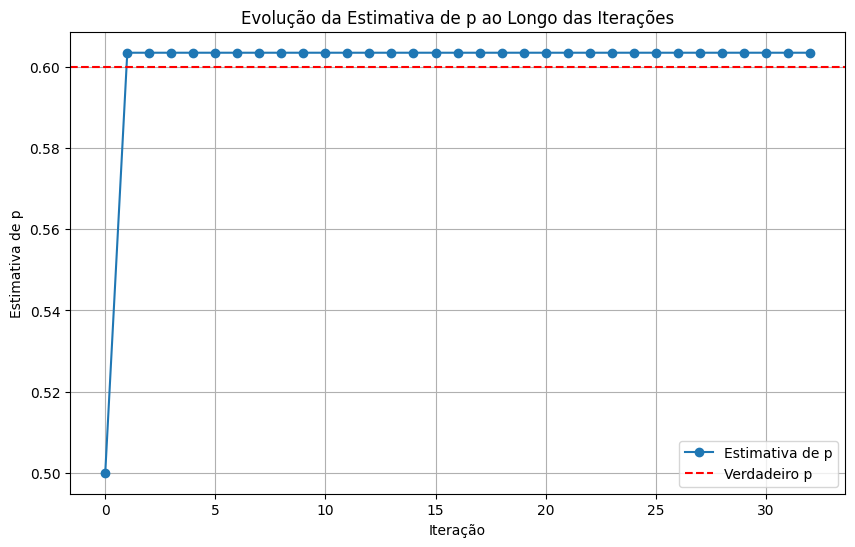

Parâmetros verdadeiros λ: [16.01 23.04 43.05]
Parâmetros estimados λ: [15.48537344 24.00989259 42.29473397]
Valor verdadeiro de p: 0.6
Valor estimado de p: 0.6034967599951094


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Configurações do modelo

# Parâmetros verdadeiros
lambda_true = np.array([16.01, 23.04, 43.05])  # Taxas de Poisson
p_true = 0.6  # Probabilidade verdadeira para X_i (scalar)

# Número de amostras
n_samples = 100

# Função para gerar dados
def generate_data(lambda_true, p_true, n_samples):
    Y = []
    for i in range(len(lambda_true)):
        Y_i = poisson.rvs((1 - p_true) * lambda_true[i], size=n_samples)
        Y.append(Y_i)
    Y = np.array(Y)
    S_true = np.sum(lambda_true)
    Z = poisson.rvs(p_true * S_true, size=n_samples)
    return Y, Z

# Gerar dados simulados
Y, Z = generate_data(lambda_true, p_true, n_samples)

# Função do algoritmo EM com rastreamento da evolução dos parâmetros
def em_algorithm(Y, Z, max_iter=100, tol=1e-6):
    n = len(Y)  # Número de componentes (i)
    n_samples = Y.shape[1]  # Número de amostras (n)
    lambda_est = np.ones(n)  # Inicializar lambda com 1
    p_est = 0.5  # Inicializar p com um valor inicial
    lambda_history = [lambda_est.copy()]  # Histórico das estimativas de lambda
    p_history = [p_est]  # Histórico das estimativas de p

    for _ in range(max_iter):
        S_est = np.sum(lambda_est)  # Somatório das estimativas lambda atuais

        # Etapa E: Calcular a esperança condicional dos X não observados
        E_X = np.array([
            Z * (p_est * lambda_est[i]) / (p_est * S_est)
            for i in range(n)
        ])  # E_X tem shape (n, n_samples)
        # Simplifica para:
        E_X = np.array([
            Z * lambda_est[i] / S_est
            for i in range(n)
        ])

        # Etapa M: Atualizar lambda
        lambda_new = np.array([
            np.sum(E_X[i] + Y[i]) / n_samples
            for i in range(n)
        ])

        # Atualizar p
        total_E_X = np.sum(E_X)
        total_Y = np.sum(Y)
        p_new = total_E_X / (total_E_X + total_Y)

        # Adicionar as novas estimativas ao histórico
        lambda_history.append(lambda_new.copy())
        p_history.append(p_new)

        # Verificar convergência
        if np.all(np.abs(lambda_new - lambda_est) < tol) and np.abs(p_new - p_est) < tol:
            break

        lambda_est = lambda_new
        p_est = p_new

    return lambda_est, p_est, lambda_history, p_history

# Aplicar o algoritmo EM
lambda_estimated, p_estimated, lambda_history, p_history = em_algorithm(Y, Z)

# Plotar a evolução das estimativas de lambda
plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b']  # Definir cores para cada parâmetro
n_params = len(lambda_true)

for i in range(n_params):
    # Plotar evolução das estimativas
    plt.plot([l[i] for l in lambda_history], label=f'Estimativa λ{i+1}', marker='o', color=colors[i])
    # Plotar linha horizontal do valor verdadeiro
    plt.axhline(y=lambda_true[i], color=colors[i], linestyle='--', label=f'Verdadeiro λ{i+1}')

plt.xlabel('Iteração')
plt.ylabel('Estimativa dos Parâmetros λ')
plt.title('Evolução das Estimativas dos Parâmetros λ ao Longo das Iterações')
plt.legend()
plt.grid(True)
plt.show()

# Plotar a evolução da estimativa de p
plt.figure(figsize=(10, 6))
plt.plot(p_history, label='Estimativa de p', marker='o')
plt.axhline(y=p_true, color='r', linestyle='--', label='Verdadeiro p')
plt.xlabel('Iteração')
plt.ylabel('Estimativa de p')
plt.title('Evolução da Estimativa de p ao Longo das Iterações')
plt.legend()
plt.grid(True)
plt.show()

print("Parâmetros verdadeiros λ:", lambda_true)
print("Parâmetros estimados λ:", lambda_estimated)
print("Valor verdadeiro de p:", p_true)
print("Valor estimado de p:", p_estimated)


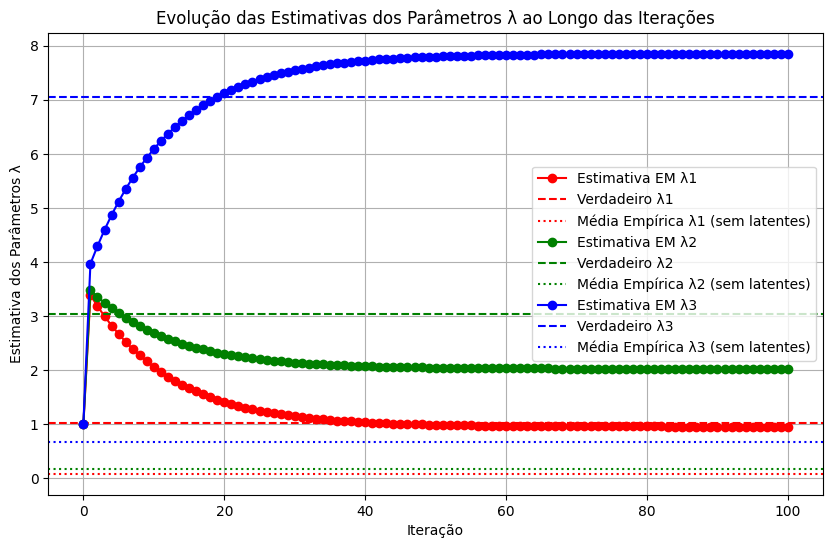

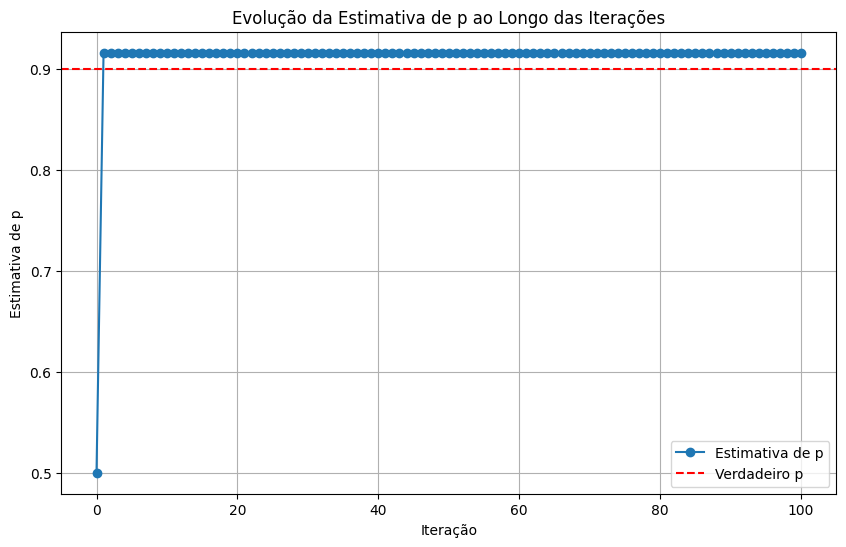

Parâmetros verdadeiros λ: [1.01 3.04 7.05]
Parâmetros estimados λ: [0.95249799 2.02343163 7.85407038]
Médias empíricas dos valores observados (sem latentes): [0.08 0.17 0.66]
Valor verdadeiro de p: 0.9
Valor estimado de p: 0.9159741458910434


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Configurações do modelo

# Parâmetros verdadeiros
lambda_true = np.array([1.01, 3.04, 7.05])  # Taxas de Poisson
p_true = 0.9  # Probabilidade verdadeira para X_i (scalar)

# Número de amostras
n_samples = 100

# Função para gerar dados
def generate_data(lambda_true, p_true, n_samples):
    Y = []
    for i in range(len(lambda_true)):
        Y_i = poisson.rvs((1 - p_true) * lambda_true[i], size=n_samples)
        Y.append(Y_i)
    Y = np.array(Y)
    S_true = np.sum(lambda_true)
    Z = poisson.rvs(p_true * S_true, size=n_samples)
    return Y, Z

# Gerar dados simulados
Y, Z = generate_data(lambda_true, p_true, n_samples)

# Cálculo da média empírica dos valores observados (sem considerar valores latentes)
lambda_empirical = np.mean(Y, axis=1)

# Função do algoritmo EM com rastreamento da evolução dos parâmetros
def em_algorithm(Y, Z, max_iter=100, tol=1e-6):
    n = len(Y)  # Número de componentes (i)
    n_samples = Y.shape[1]  # Número de amostras (n)
    lambda_est = np.ones(n)  # Inicializar lambda com 1
    p_est = 0.5  # Inicializar p com um valor inicial
    lambda_history = [lambda_est.copy()]  # Histórico das estimativas de lambda
    p_history = [p_est]  # Histórico das estimativas de p

    for _ in range(max_iter):
        S_est = np.sum(lambda_est)  # Somatório das estimativas lambda atuais

        # Etapa E: Calcular a esperança condicional dos X não observados
        # Como p cancela no numerador e denominador, o cálculo é simplificado
        E_X = np.array([
            Z * lambda_est[i] / S_est
            for i in range(n)
        ])  # E_X tem shape (n, n_samples)

        # Etapa M: Atualizar lambda
        lambda_new = np.array([
            np.sum(E_X[i] + Y[i]) / n_samples
            for i in range(n)
        ])

        # Atualizar p
        total_E_X = np.sum(E_X)
        total_Y = np.sum(Y)
        p_new = total_E_X / (total_E_X + total_Y)

        # Adicionar as novas estimativas ao histórico
        lambda_history.append(lambda_new.copy())
        p_history.append(p_new)

        # Verificar convergência
        if np.all(np.abs(lambda_new - lambda_est) < tol) and np.abs(p_new - p_est) < tol:
            break

        lambda_est = lambda_new
        p_est = p_new

    return lambda_est, p_est, lambda_history, p_history

# Aplicar o algoritmo EM
lambda_estimated, p_estimated, lambda_history, p_history = em_algorithm(Y, Z)

# Plotar a evolução das estimativas de lambda
plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b']  # Definir cores para cada parâmetro
n_params = len(lambda_true)

for i in range(n_params):
    # Plotar evolução das estimativas
    plt.plot([l[i] for l in lambda_history], label=f'Estimativa EM λ{i+1}', marker='o', color=colors[i])
    # Plotar linha horizontal do valor verdadeiro
    plt.axhline(y=lambda_true[i], color=colors[i], linestyle='--', label=f'Verdadeiro λ{i+1}')
    # Plotar linha horizontal da média empírica
    plt.axhline(y=lambda_empirical[i], color=colors[i], linestyle=':', label=f'Média Empírica λ{i+1} (sem latentes)')

plt.xlabel('Iteração')
plt.ylabel('Estimativa dos Parâmetros λ')
plt.title('Evolução das Estimativas dos Parâmetros λ ao Longo das Iterações')
plt.legend()
plt.grid(True)
plt.show()

# Plotar a evolução da estimativa de p
plt.figure(figsize=(10, 6))
plt.plot(p_history, label='Estimativa de p', marker='o')
plt.axhline(y=p_true, color='r', linestyle='--', label='Verdadeiro p')
plt.xlabel('Iteração')
plt.ylabel('Estimativa de p')
plt.title('Evolução da Estimativa de p ao Longo das Iterações')
plt.legend()
plt.grid(True)
plt.show()

print("Parâmetros verdadeiros λ:", lambda_true)
print("Parâmetros estimados λ:", lambda_estimated)
print("Médias empíricas dos valores observados (sem latentes):", lambda_empirical)
print("Valor verdadeiro de p:", p_true)
print("Valor estimado de p:", p_estimated)


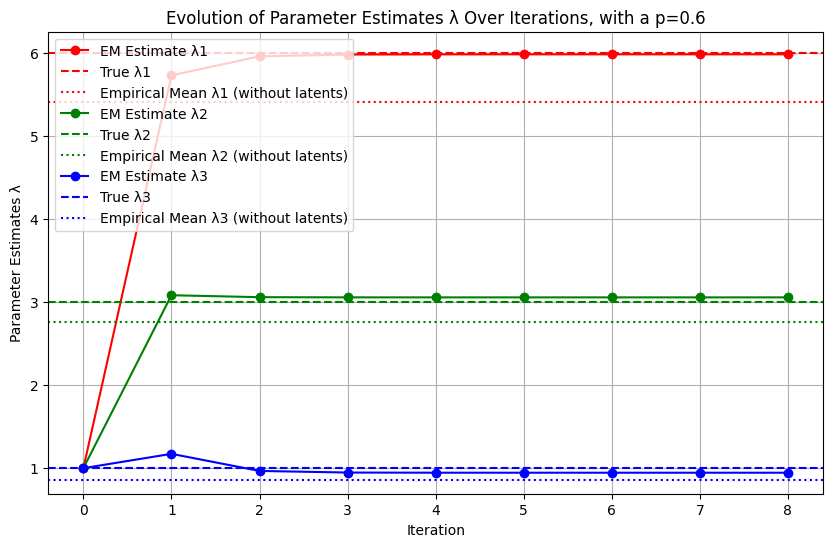

True parameters λ: [6. 3. 1.]
Estimated parameters λ: [5.98041957 3.05543074 0.94514969]
Empirical means of observed values (without latents): [5.41  2.764 0.855]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Model configurations

# True parameters
lambda_true = np.array([6.0, 3.0, 1.0])  # Poisson ates
p_true = 0.1  # True probability for X_i (scalar)

# Number of samples
n_samples = 1000

# Function to generate data
def generate_data(lambda_true, p_true, n_samples):
    Y = []
    for i in range(len(lambda_true)):
        Y_i = poisson.rvs((1 - p_true) * lambda_true[i], size=n_samples)
        Y.append(Y_i)
    Y = np.array(Y)
    S_true = np.sum(lambda_true)
    Z = poisson.rvs(p_true * S_true, size=n_samples)
    return Y, Z

# Generate simulated data
Y, Z = generate_data(lambda_true, p_true, n_samples)

# Calculate empirical mean of observed values (without considering latent values)
lambda_empirical = np.mean(Y, axis=1)

# EM algorithm function with tracking of parameter evolution
def em_algorithm(Y, Z, max_iter=50, tol=1e-6):
    n = len(Y)  # Number of components (i)
    n_samples = Y.shape[1]  # Number of samples (n)
    lambda_est = np.ones(n)  # Initialize lambda with 1
    lambda_history = [lambda_est.copy()]  # History of lambda estimates

    for _ in range(max_iter):
        S_est = np.sum(lambda_est)  # Sum of current lambda estimates

        # E-Step: Compute the conditional expectation of unobserved X
        # Since p cancels out in numerator and denominator, calculation is simplified
        E_X = np.array([
            Z * lambda_est[i] / S_est
            for i in range(n)
        ])  # E_X has shape (n, n_samples)

        # M-Step: Update lambda
        lambda_new = np.array([
            np.sum(E_X[i] + Y[i]) / n_samples
            for i in range(n)
        ])

        # Add new estimates to history
        lambda_history.append(lambda_new.copy())

        # Check convergence
        if np.all(np.abs(lambda_new - lambda_est) < tol):
            break

        lambda_est = lambda_new

    return lambda_est, lambda_history

# Apply the EM algorithm
lambda_estimated, lambda_history = em_algorithm(Y, Z)

# Plot the evolution of lambda estimates
plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b']  # Define colors for each parameter
n_params = len(lambda_true)

for i in range(n_params):
    # Plot evolution of estimates
    plt.plot([l[i] for l in lambda_history], label=f'EM Estimate λ{i+1}', marker='o', color=colors[i])
    # Plot horizontal line for true value
    plt.axhline(y=lambda_true[i], color=colors[i], linestyle='--', label=f'True λ{i+1}')
    # Plot horizontal line for empirical mean
    plt.axhline(y=lambda_empirical[i], color=colors[i], linestyle=':', label=f'Empirical Mean λ{i+1} (without latents)')

plt.xlabel('Iteration')
plt.ylabel('Parameter Estimates λ')
plt.title('Evolution of Parameter Estimates λ Over Iterations, with a p=0.6')
plt.legend()
plt.grid(True)
plt.show()

print("True parameters λ:", lambda_true)
print("Estimated parameters λ:", lambda_estimated)
print("Empirical means of observed values (without latents):", lambda_empirical)


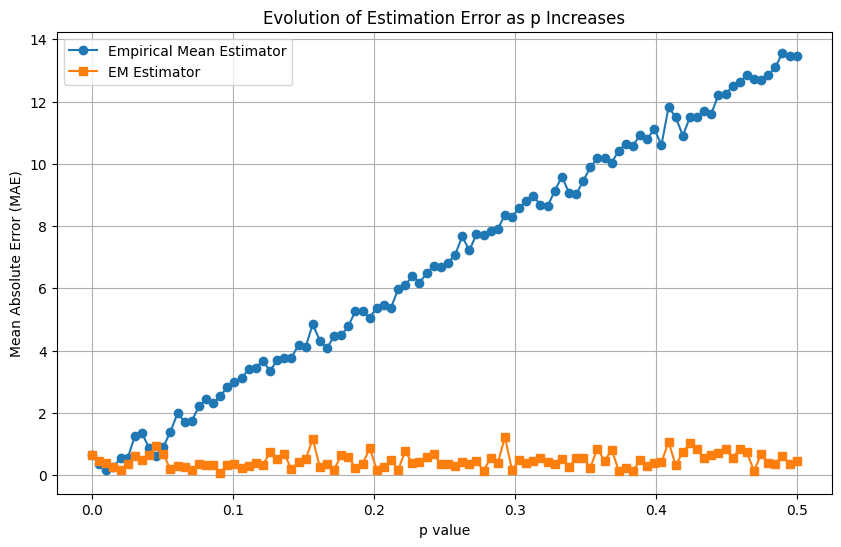

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# True parameters
lambda_true = np.array([16.01, 23.04, 43.05])  # Poisson rates
n_samples = 100  # Number of samples

# Range of p values to test
p_values = np.linspace(0, 0.5, 100)  # p from 0 to 0.9 in steps of 0.1

# Lists to store errors for each estimator
errors_empirical = []
errors_em = []

# EM algorithm function
def em_algorithm(Y, Z, max_iter=100, tol=1e-6):
    n = len(Y)  # Number of components (i)
    n_samples = Y.shape[1]  # Number of samples (n)
    lambda_est = np.ones(n)  # Initialize lambda with 1
    lambda_history = [lambda_est.copy()]  # History of lambda estimates

    for _ in range(max_iter):
        S_est = np.sum(lambda_est)  # Sum of current lambda estimates

        # E-Step: Compute the conditional expectation of unobserved X
        E_X = np.array([
            Z * lambda_est[i] / S_est
            for i in range(n)
        ])  # E_X has shape (n, n_samples)

        # M-Step: Update lambda
        lambda_new = np.array([
            np.sum(E_X[i] + Y[i]) / n_samples
            for i in range(n)
        ])

        # Add new estimates to history
        lambda_history.append(lambda_new.copy())

        # Check convergence
        if np.all(np.abs(lambda_new - lambda_est) < tol):
            break

        lambda_est = lambda_new

    return lambda_est, lambda_history

# Loop over different p values
for p_true in p_values:
    # Function to generate data
    def generate_data(lambda_true, p_true, n_samples):
        Y = []
        for i in range(len(lambda_true)):
            Y_i = poisson.rvs((1 - p_true) * lambda_true[i], size=n_samples)
            Y.append(Y_i)
        Y = np.array(Y)
        S_true = np.sum(lambda_true)
        Z = poisson.rvs(p_true * S_true, size=n_samples)
        return Y, Z

    # Generate simulated data
    Y, Z = generate_data(lambda_true, p_true, n_samples)

    # Empirical mean estimator (without considering latent values)
    lambda_empirical = np.mean(Y, axis=1)

    # Apply the EM algorithm
    lambda_estimated_em, _ = em_algorithm(Y, Z)

    # Calculate errors for both estimators
    error_empirical = np.mean(np.abs(lambda_empirical - lambda_true))
    error_em = np.mean(np.abs(lambda_estimated_em - lambda_true))

    # Store errors
    errors_empirical.append(error_empirical)
    errors_em.append(error_em)

# Plotting the errors versus p
plt.figure(figsize=(10, 6))
plt.plot(p_values, errors_empirical, label='Empirical Mean Estimator', marker='o')
plt.plot(p_values, errors_em, label='EM Estimator', marker='s')
plt.xlabel('p value')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Evolution of Estimation Error as p Increases')
plt.legend()
plt.grid(True)
plt.show()


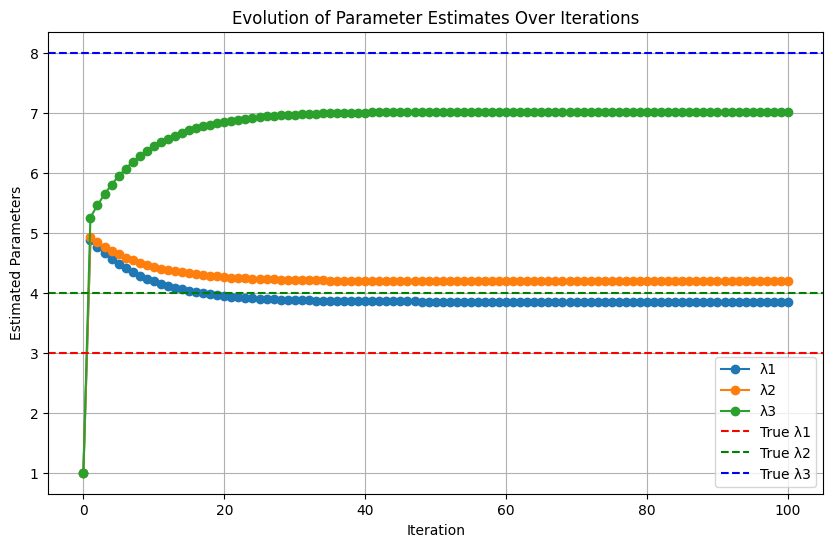

Parâmetros verdadeiros: [3. 4. 8.]
Parâmetros estimados: [3.85057287 4.19284422 7.01658291]


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Configurações do modelo
np.random.seed(42)  # Para reprodutibilidade

# Parâmetros verdadeiros
lambda_true = np.array([3.0, 4.0, 8.0])  # Taxas de Poisson
p_true = np.array([0.9, 0.9, 0.9])  # Probabilidades para X_i

# Número de amostras
n_samples = 100

# Função para gerar dados
def generate_data(lambda_true, p_true, n_samples):
    X = []
    Y = []
    for i in range(len(lambda_true)):
        X_i = poisson.rvs(p_true[i] * lambda_true[i], size=n_samples)
        Y_i = poisson.rvs((1 - p_true[i]) * lambda_true[i], size=n_samples)
        X.append(X_i)
        Y.append(Y_i)
    X = np.array(X)
    Y = np.array(Y)
    S = np.sum(X, axis=0)
    return X, Y, S

# Gerar dados simulados
X, Y, S = generate_data(lambda_true, p_true, n_samples)

# Função do algoritmo EM com rastreamento da evolução dos parâmetros
def em_algorithm(Y, S, p_true, max_iter=100, tol=1e-6):
    n = len(p_true)
    lambda_est = np.ones(n)  # Inicializar lambda com 1
    lambda_history = [lambda_est.copy()]  # Lista para armazenar histórico das estimativas

    for _ in range(max_iter):
        # Etapa E: Calcular a esperança condicional
        X_conditional_mean = np.array([
            S * (p_true[i] * lambda_est[i]) / np.sum(p_true * lambda_est)
            for i in range(n)
        ])

        # Etapa M: Atualizar lambda
        lambda_new = np.array([
            np.mean(X_conditional_mean[i] + Y[i])
            for i in range(n)
        ])

        # Adicionar a nova estimativa ao histórico
        lambda_history.append(lambda_new.copy())

        # Verificar convergência
        if np.all(np.abs(lambda_new - lambda_est) < tol):
            break

        lambda_est = lambda_new

    return lambda_est, lambda_history

# Aplicar o algoritmo EM
lambda_estimated, lambda_history = em_algorithm(Y, S, p_true)

# Plotar a evolução das estimativas
plt.figure(figsize=(10, 6))
for i in range(len(lambda_true)):
    plt.plot([l[i] for l in lambda_history], label=f'λ{i+1}', marker='o')

plt.axhline(y=lambda_true[0], color='r', linestyle='--', label='True λ1')
plt.axhline(y=lambda_true[1], color='g', linestyle='--', label='True λ2')
plt.axhline(y=lambda_true[2], color='b', linestyle='--', label='True λ3')

plt.xlabel('Iteration')
plt.ylabel('Estimated Parameters')
plt.title('Evolution of Parameter Estimates Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

print("Parâmetros verdadeiros:", lambda_true)
print("Parâmetros estimados:", lambda_estimated)